In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
#from scipy.stats import skew
#from scipy.stats import kurtosis
#from scipy.spatial import distance
import numpy as np
#from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope
#from scipy.stats import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.svm import OneClassSVM
import matplotlib.font_manager
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.gridspec as gridspec
import itertools

In [2]:
dfEnem2018 = pd.read_csv('DADOS\MICRODADOS_ENEM_2018.csv',encoding='latin-1',sep=';')
dfEnem2018.head()

NU_INSCRICAO  NU_ANO  CO_MUNICIPIO_RESIDENCIA NO_MUNICIPIO_RESIDENCIA  \
0  180008202043    2018                  5300108                Brasília   
1  180007197856    2018                  2111102      São João dos Patos   
2  180008517434    2018                  3530607         Mogi das Cruzes   
3  180007661228    2018                  2916401              Itapetinga   
4  180008787987    2018                  2918100               Jeremoabo   

   CO_UF_RESIDENCIA SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_ESTADO_CIVIL  \
0                53               DF      44.0       M              1.0   
1                21               MA      23.0       F              0.0   
2                35               SP      23.0       F              0.0   
3                29               BA      26.0       F              0.0   
4                29               BA      20.0       M              0.0   

   TP_COR_RACA  ...   Q018  Q019 Q020  Q021 Q022  Q023  Q024  Q025  Q026  Q027  
0            1  ...      A     A    A     A    A     A     A     A     B     A  
1            3  ...      A     B    A     A    B     A     A     A     A     A  
2            1  ...      A     B    A     A    B     B     B     B     A     A  
3            3  ...      A     B    B     A    C     A     B     B     A     A  
4            0  ...      A     B    A     A    B     A     B     B     B     A  

[5 rows x 137 columns]

<h2>O Dataset</h2>

<br/><br/>NU_INSCRICAO - Número de inscrição
<br/>CO_UF_RESIDENCIA - Código da Unidade da Federação de residência
<br/>TP_COR_RACA - Cor/raça
<br/>TP_ST_CONCLUSAO - Situação de conclusão do Ensino Médio
<br/>TP_ANO_CONCLUIU - Ano de Conclusão do Ensino Médio
<br/>TP_ESCOLA - Tipo de escola do Ensino Médio
<br/>Q001 - Até que série seu pai, ou o homem responsável por você, estudou?
<br/>Q002 - Até que série sua mãe, ou a mulher responsável por você, estudou?
<br/>Q003 - A partir da apresentação de algumas ocupações divididas em grupos ordenados, indique o grupo que contempla a ocupação mais próxima da ocupação do seu pai ou do homem responsável por você. (Se ele não estiver trabalhando, escolha uma ocupação pensando no último trabalho dele).
<br/>Q004 - A partir da apresentação de algumas ocupações divididas em grupos ordenados, indique o grupo que contempla a ocupação mais próxima da ocupação da sua mãe ou da mulher responsável por você. (Se ela não estiver trabalhando, escolha uma ocupação pensando no último trabalho dela).
<br/>Q005 - Incluindo você, quantas pessoas moram atualmente em sua residência?
<br/>Q006 - Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)
<br/>Q007 - Em sua residência trabalha empregado(a) doméstico(a)?
<br/>Q008 - Na sua residência tem banheiro?
<br/>Q009 - Na sua residência tem quartos para dormir?
<br/>Q010 - Na sua residência tem carro?
<br/>Q011 - Na sua residência tem motocicleta?
<br/>Q012 - Na sua residência tem geladeira?
<br/>Q013 - Na sua residência tem freezer (independente ou segunda porta da geladeira)?
<br/>Q014 - Na sua residência tem máquina de lavar roupa? (o tanquinho NÃO deve ser considerado)
<br/>Q015 - Na sua residência tem máquina de secar roupa (independente ou em conjunto com a máquina de lavar roupa)?
<br/>Q016 - Na sua residência tem forno micro-ondas?
<br/>Q017 - Na sua residência tem máquina de lavar louça?
<br/>Q018 - Na sua residência tem aspirador de pó?
<br/>Q019 - Na sua residência tem televisão em cores?
<br/>Q020 - Na sua residência tem aparelho de DVD?
<br/>Q021 - Na sua residência tem TV por assinatura?
<br/>Q022 - Na sua residência tem telefone celular?
<br/>Q023 - Na sua residência tem telefone fixo?
<br/>Q024 - Na sua residência tem computador?
<br/>Q025 - Na sua residência tem acesso à Internet?
<br/>Q026 - Você já concluiu ou está concluindo o Ensino Médio?
<br/>Q027 - Em que tipo de escola você frequentou o Ensino Médio?

In [3]:
dfEnem2018.shape

(5513747, 137)

In [3]:
drop_these = list(set(list(dfEnem2018.columns)) - set(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']))

dfEnem2018.drop(drop_these,axis=1,inplace=True)

dfEnem2018 = dfEnem2018[dfEnem2018.TP_PRESENCA_CH == 1]
dfEnem2018['NU_NOTA_TOTAL'] = round((dfEnem2018['NU_NOTA_CN'].fillna(value=0) + dfEnem2018['NU_NOTA_CH'] 
                        + dfEnem2018['NU_NOTA_LC'] + dfEnem2018['NU_NOTA_MT'].fillna(value=0)
                        + dfEnem2018['NU_NOTA_REDACAO']) / 5,2)

#Colunas com NA
#NU_NOTA_CN - 254521
#NU_NOTA_MT - 254521
#Q026 - 4
#remover os participantes com notas zeradas

#dfEnem2018['NU_NOTA_CN'].fillna(0,inplace=True) #replacement por 0
#dfEnem2018['NU_NOTA_MT'].fillna(0,inplace=True) #replacement por 0
dfEnem2018.dropna(inplace=True)

#removendo as notas 0 de redação
dfEnem2018.drop(dfEnem2018.loc[dfEnem2018.NU_NOTA_REDACAO == 0,:].index,axis=0,inplace=True)

for column in [x for x in dfEnem2018.drop('Q005',axis=1).columns if 'Q0' in x]:
    dfEnem2018[column] = dfEnem2018[column].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16})
    
resp = pd.read_csv('Auxilio - Respostas Questionario.csv',sep=';')

for nota in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL']:
    print('Prova ' + nota + '. \tQuantidade de 0: ' + str(dfEnem2018.loc[dfEnem2018[nota] == 0].shape[0]))
    if nota in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']:
        print('\tFaltas: ' + str(dfEnem2018.loc[dfEnem2018[str(nota).replace('NU_NOTA','TP_PRESENCA')] == 0].shape[0]))
        
dfEnem2018.drop(['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'],axis=1,inplace=True)

Prova NU_NOTA_CN. 	Quantidade de 0: 502
	Faltas: 0
Prova NU_NOTA_CH. 	Quantidade de 0: 2968
	Faltas: 0
Prova NU_NOTA_LC. 	Quantidade de 0: 1055
	Faltas: 0
Prova NU_NOTA_MT. 	Quantidade de 0: 606
	Faltas: 0
Prova NU_NOTA_REDACAO. 	Quantidade de 0: 0
Prova NU_NOTA_TOTAL. 	Quantidade de 0: 0


In [5]:
#Resultado final depois das transformações
dfEnem2018.shape

(3813157, 39)

<h2>Verificando a correlação entre as variáveis</h2>

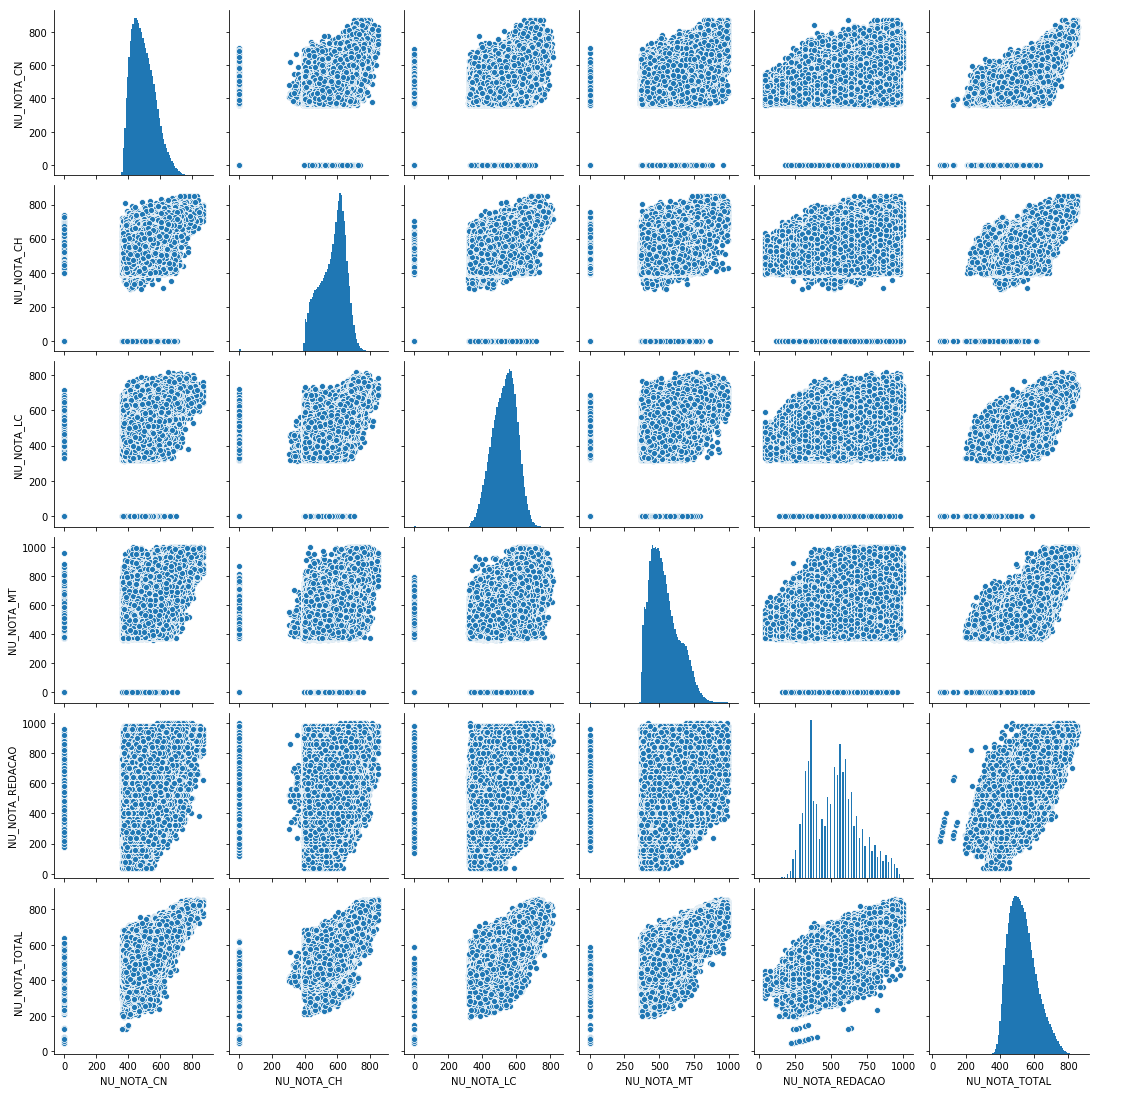

In [6]:
sns.pairplot(dfEnem2018, vars = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL'], diag_kws=dict(bins=100) )
#sns.pairplot(dfEnem2018, vars = ['CO_UF_RESIDENCIA', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL'] )
#sns.pairplot(dfEnem2018, vars = ['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027'] )

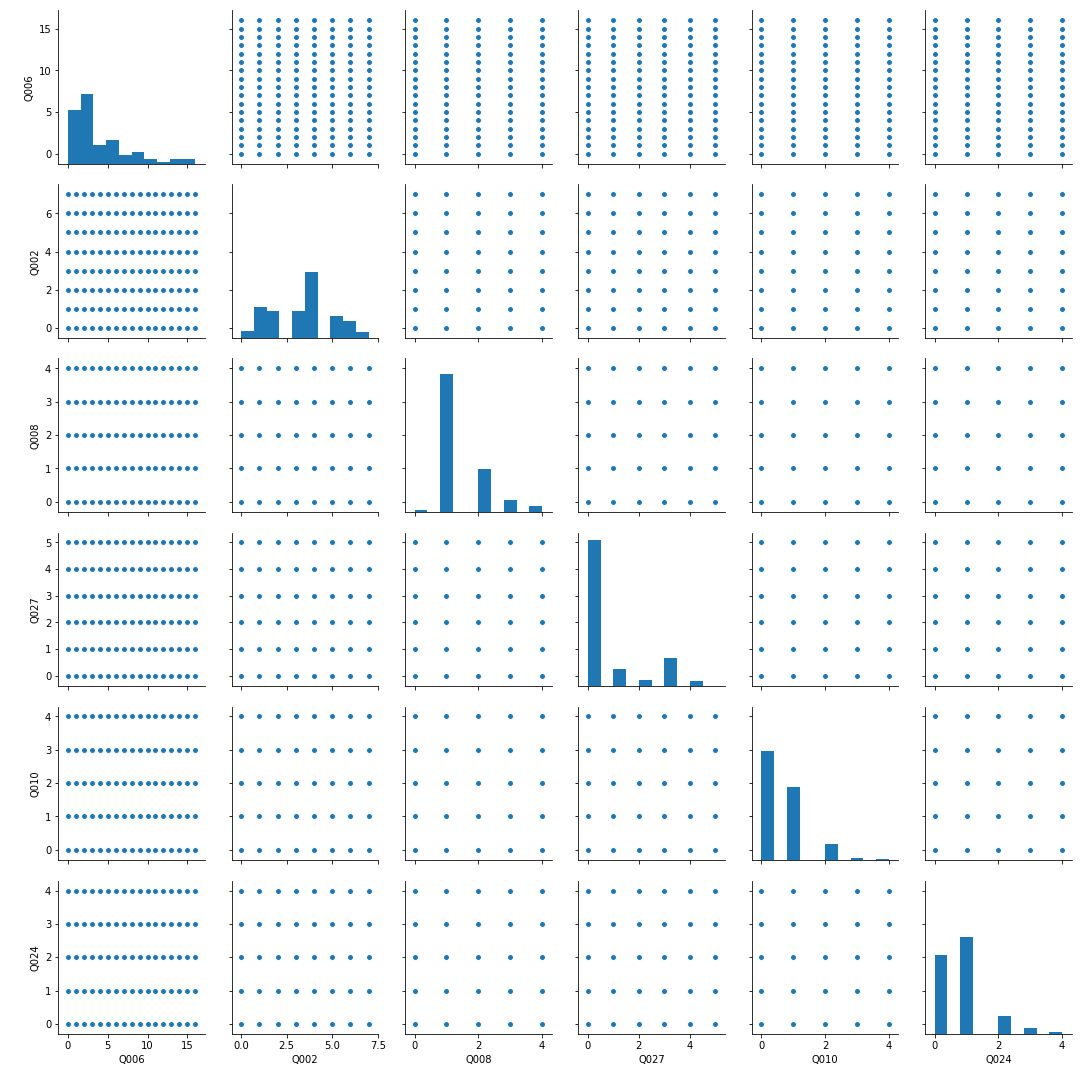

In [11]:
sns.pairplot(dfEnem2018, vars = ['Q006', 'Q002', 'Q008', 'Q027', 'Q010', 'Q024'] )

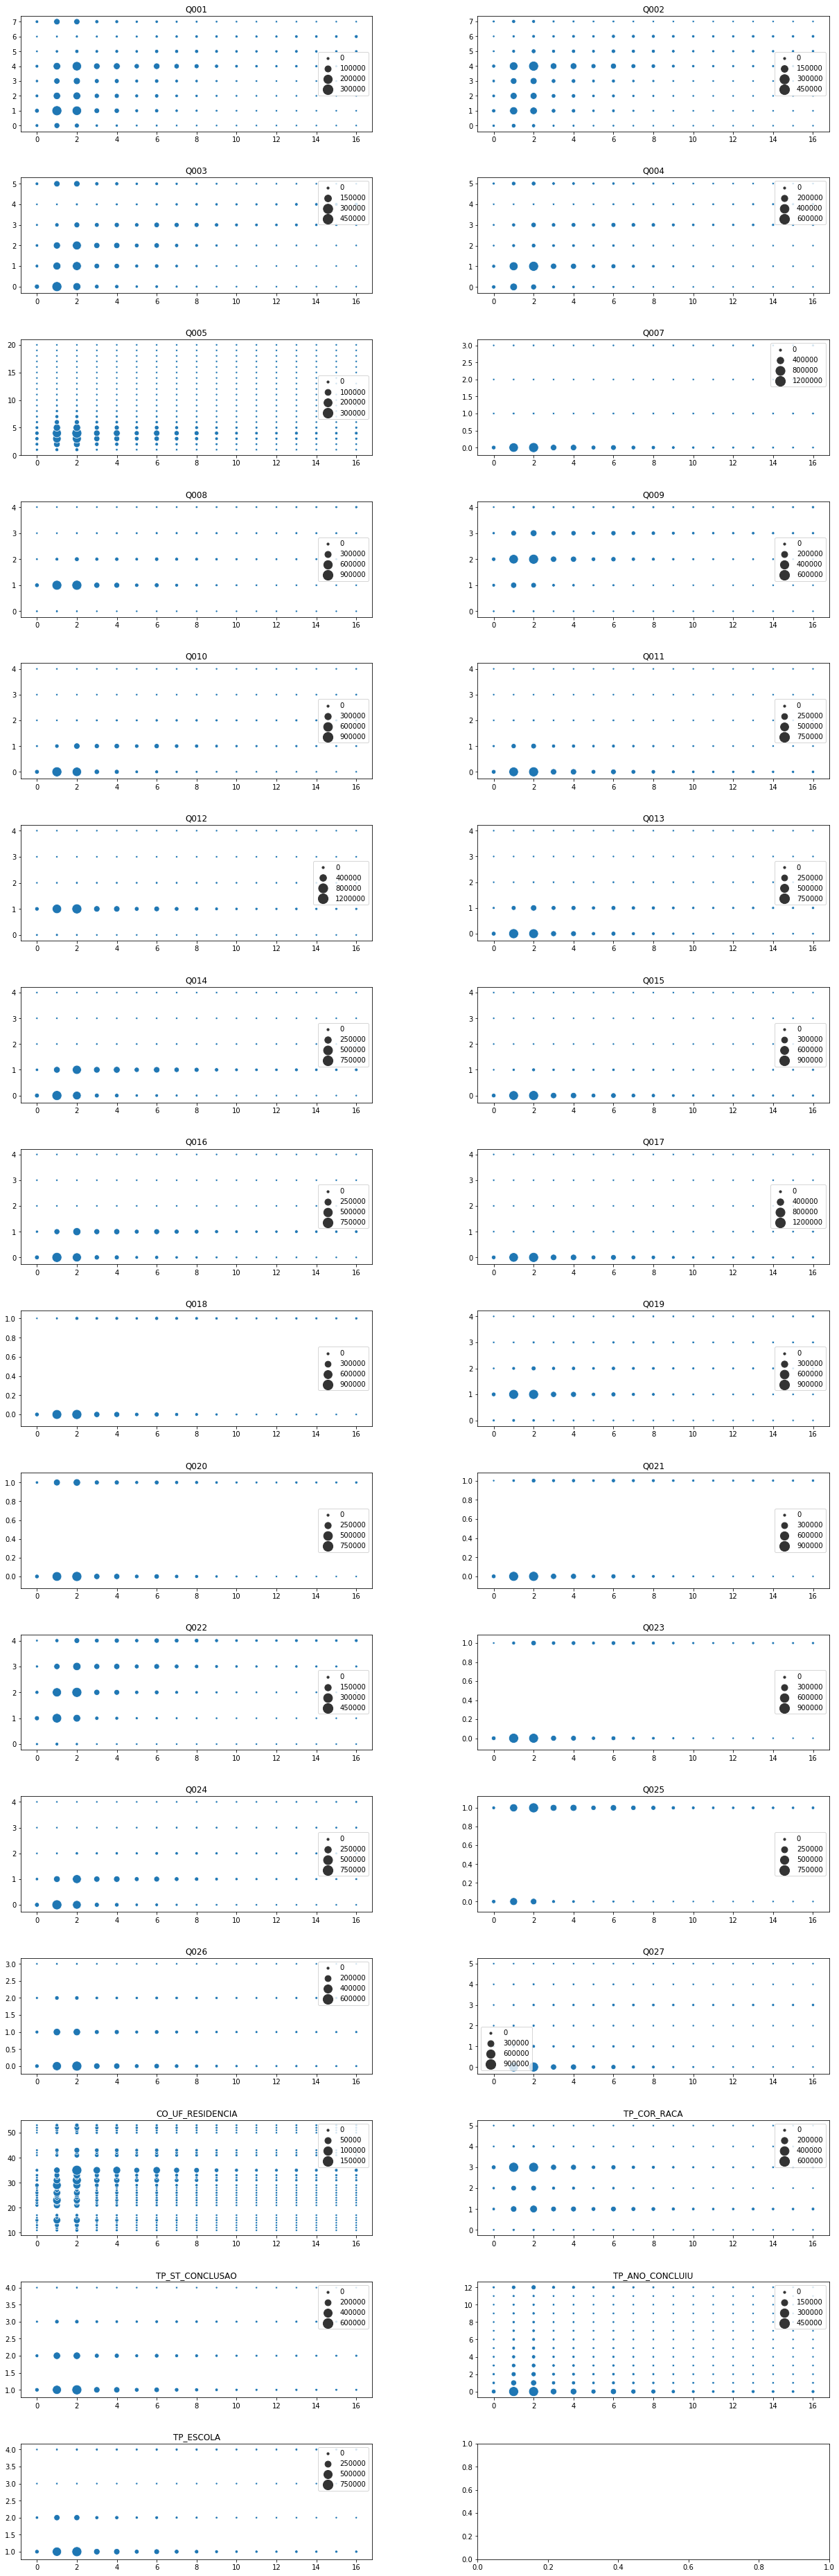

In [89]:
#dict(dfEnem2018.groupby(['Q001','Q006']).size())

fig, axs = plt.subplots(16, 2)

for column, eixo in zip(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027', 'CO_UF_RESIDENCIA', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA'],itertools.product(np.arange(16),np.arange(2))):
    
    u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', column]).size()).keys()))
    c = list(dict(dfEnem2018.groupby(['Q006',column]).size()).values())
    
    sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), ax=axs[eixo] )
    axs[eixo].set_title(column)
    axs[eixo].set(ylabel='')

    
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
fig.set_size_inches(18,60)

O Pairplot e o Regplot não mostraram um resultado visível. Verificando o coeficiente de Pearson e Spearman de todas as variáveis com a renda.

In [18]:
c = pd.DataFrame(columns=['Variavel','Pearson','Spearman'])

for column in ['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027', 'CO_UF_RESIDENCIA', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA']:
    corrP, P = pearsonr(dfEnem2018['Q006'], dfEnem2018[column])
    corrS, S = spearmanr(dfEnem2018['Q006'], dfEnem2018[column])
    c = c.append(pd.DataFrame([[column,corrP,corrS]],columns=['Variavel','Pearson','Spearman']),ignore_index=True)

In [21]:
c.sort_values(by=['Pearson','Spearman'],ascending=False)

Variavel   Pearson  Spearman
6               Q008  0.625983  0.523422
8               Q010  0.615339  0.599990
22              Q024  0.579433  0.543905
17              Q019  0.530004  0.464505
25              Q027  0.518321  0.451582
16              Q018  0.481843  0.444628
19              Q021  0.477078  0.437156
20              Q022  0.455487  0.504453
12              Q014  0.426834  0.489668
5               Q007  0.425679  0.297997
7               Q009  0.417854  0.404401
14              Q016  0.414314  0.453233
21              Q023  0.402405  0.406569
1               Q002  0.401597  0.405914
3               Q004  0.398585  0.435368
11              Q013  0.386439  0.373413
23              Q025  0.344329  0.421357
2               Q003  0.343496  0.377150
0               Q001  0.334969  0.344676
10              Q012  0.263494  0.227344
15              Q017  0.260907  0.182631
13              Q015  0.248375  0.226900
26  CO_UF_RESIDENCIA  0.214219  0.316740
30         TP_ESCOLA  0.188734  0.034322
18              Q020  0.187518  0.158571
28   TP_ST_CONCLUSAO  0.162165  0.107484
24              Q026  0.162163  0.107484
4               Q005  0.006610  0.029726
9               Q011  0.002140  0.022894
29   TP_ANO_CONCLUIU -0.080961 -0.073869
27       TP_COR_RACA -0.255924 -0.258323

<h2>Verificando quais variaveis são mais importantes</h2>

In [4]:
from sklearn.feature_selection import f_regression
d = dict()

for nota in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL']:
    
    #algoritmo de seleção
    selector = SelectKBest(f_regression,k='all')
    selector.fit(dfEnem2018.drop(['NU_INSCRICAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL'], axis = 1),dfEnem2018[nota])

    #dicionarizando as notas
    keys = dfEnem2018.drop(['NU_INSCRICAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL'], axis = 1).columns
    #print(selector.scores_)
    values = [round(elem, 2) for elem in selector.scores_]
    d[nota] = dict(zip(keys, values))

Resultado utilizando f_regression

In [5]:
for nota in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL']:
    print(nota)
    print({k: v for k, v in sorted(d[nota].items(), key=lambda item: item[1], reverse=True)[:10]})
    print('\n')

NU_NOTA_CN
{'Q006': 805682.59, 'Q027': 600679.08, 'Q024': 529826.24, 'Q008': 424021.93, 'Q010': 377645.27, 'Q018': 272653.87, 'Q019': 250283.91, 'Q002': 249914.66, 'Q016': 207769.99, 'Q023': 206827.33}


NU_NOTA_CH
{'Q006': 595394.73, 'Q024': 448621.75, 'Q027': 400450.1, 'Q008': 286982.59, 'Q010': 264388.05, 'Q018': 212645.33, 'Q019': 199705.59, 'Q016': 190020.23, 'Q025': 189414.19, 'Q014': 183986.65}


NU_NOTA_LC
{'Q006': 758117.18, 'Q024': 565678.37, 'Q027': 495043.23, 'Q008': 371110.26, 'Q010': 338827.05, 'Q002': 293261.73, 'Q018': 270497.59, 'Q022': 264344.49, 'Q019': 261762.59, 'Q025': 261189.12}


NU_NOTA_MT
{'Q006': 905041.73, 'Q027': 600416.13, 'Q024': 577920.52, 'Q008': 476939.85, 'Q010': 423147.06, 'Q002': 321652.6, 'Q019': 315429.94, 'Q018': 290235.96, 'Q022': 252961.29, 'Q016': 238788.62}


NU_NOTA_REDACAO
{'Q006': 579183.37, 'Q027': 533805.71, 'Q024': 397118.64, 'Q008': 333658.93, 'Q002': 258054.4, 'Q010': 256105.61, 'Q022': 196947.0, 'Q019': 194686.71, 'Q025': 170065.32, 

Resultado utilizando f_classif

In [52]:
#f_classif
for nota in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL']:
    print(nota)
    print({k: v for k, v in sorted(d[nota].items(), key=lambda item: item[1], reverse=True)[:10]})
    print('\n')

NU_NOTA_CN
{'Q006': 208.09, 'Q027': 162.72, 'Q024': 128.79, 'Q008': 113.73, 'Q010': 93.02, 'Q018': 67.52, 'Q019': 63.42, 'Q002': 61.85, 'Q004': 50.68, 'Q021': 50.43}


NU_NOTA_CH
{'Q006': 221.64, 'Q027': 154.43, 'Q024': 152.56, 'Q008': 110.37, 'Q010': 87.01, 'Q018': 71.58, 'Q019': 67.67, 'Q002': 62.56, 'Q021': 56.88, 'Q023': 56.33}


NU_NOTA_LC
{'Q006': 209.74, 'Q024': 148.98, 'Q027': 139.57, 'Q008': 105.12, 'Q010': 86.66, 'Q002': 73.23, 'Q018': 72.37, 'Q019': 69.21, 'Q016': 62.69, 'Q022': 62.68}


NU_NOTA_MT
{'Q006': 171.09, 'Q027': 116.27, 'Q024': 104.11, 'Q008': 92.91, 'Q010': 75.64, 'Q019': 58.11, 'Q002': 55.21, 'Q018': 52.77, 'Q022': 42.66, 'Q004': 41.55}


NU_NOTA_REDACAO
{'Q006': 13072.96, 'Q027': 12676.68, 'Q024': 8556.26, 'Q008': 7736.69, 'Q010': 5657.1, 'Q002': 5615.4, 'Q019': 4306.31, 'Q022': 4184.34, 'Q004': 3675.93, 'Q025': 3590.8}


NU_NOTA_TOTAL
{'Q006': 53.07, 'Q027': 40.46, 'Q024': 34.02, 'Q008': 28.24, 'Q010': 22.41, 'Q002': 17.81, 'Q019': 17.07, 'Q018': 16.06, 'Q022'

Variáveis mais importantes:
<br/>1 - Q006 (6) - Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)
<br/>2 - Q027 (5) - Em que tipo de escola você frequentou o Ensino Médio?
<br/>3 - Q024 (5) - Na sua residência tem computador?
<br/>4 - Q008 (6) - Na sua residência tem banheiro?
<br/>5 - Q010 (6) - Na sua residência tem carro?
<br/>6 - Q002 (3) - Até que série sua mãe, ou a mulher responsável por você, estudou?
    <br/>Q018 (2) - Na sua residência tem aspirador de pó?

<h2>Motando os Boxplots pelas variáveis de Raça, Renda, Conclusão do Ensino médio e graduação da mãe</h2>

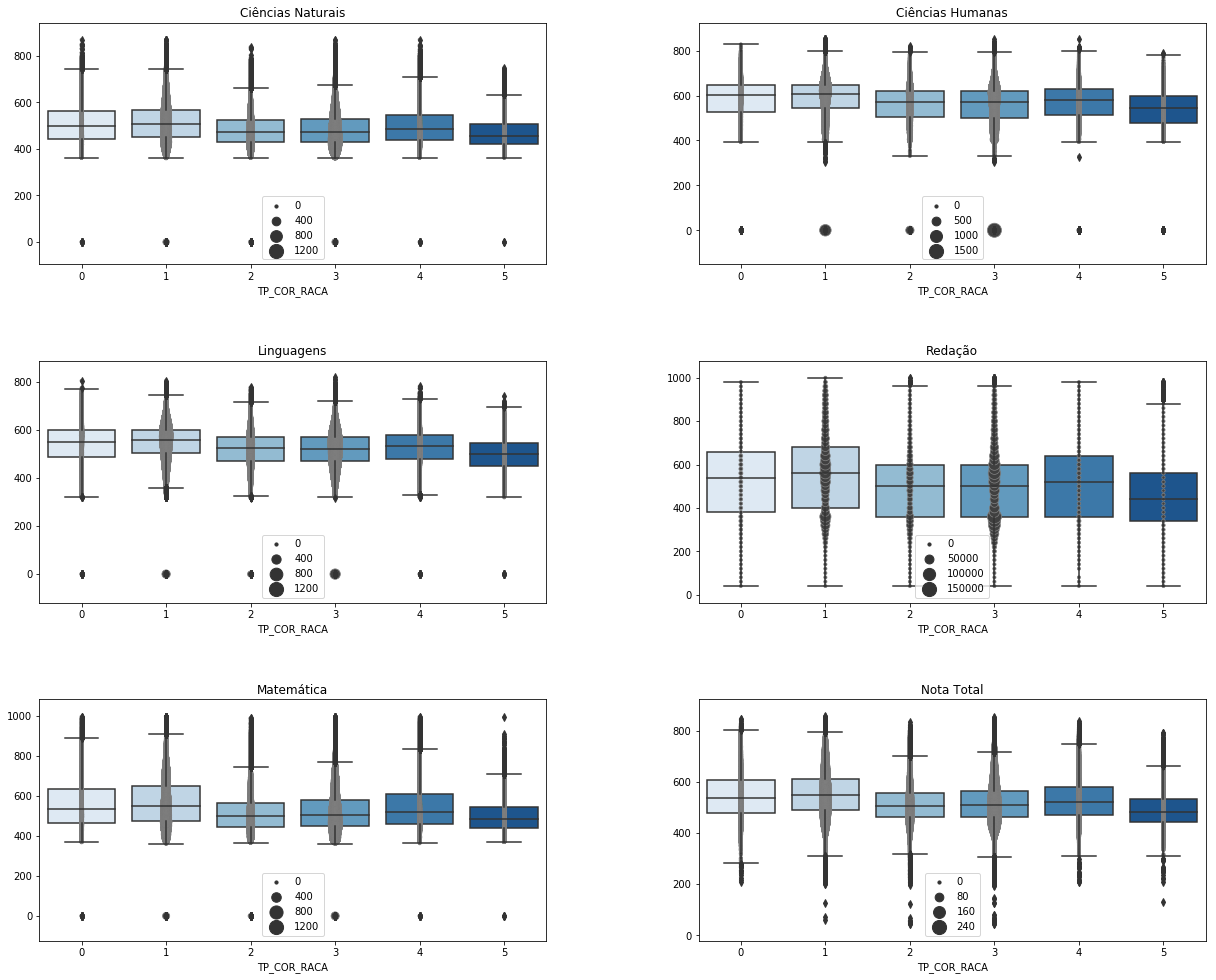

In [37]:
# RAÇA
## organizar pelo valor da mediana.. Problema abaixo
#order= dfEnem2018.groupby(['TP_COR_RACA'])['NU_NOTA_CN'].median().sort_values().index

fig, axs = plt.subplots(3, 2)

# Ciências Naturais
sns.boxplot(x=dfEnem2018['TP_COR_RACA'] ,y=dfEnem2018['NU_NOTA_CN'], palette="Blues", ax = axs[0, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['TP_COR_RACA', 'NU_NOTA_CN']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['TP_COR_RACA','NU_NOTA_CN']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 0])

axs[0, 0].set_title('Ciências Naturais')
axs[0, 0].set(ylabel='')

# Ciências Humanas
sns.boxplot(x=dfEnem2018['TP_COR_RACA'] ,y=dfEnem2018['NU_NOTA_CH'], palette="Blues", ax = axs[0, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['TP_COR_RACA', 'NU_NOTA_CH']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['TP_COR_RACA','NU_NOTA_CH']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 1])

axs[0, 1].set_title('Ciências Humanas')
axs[0, 1].set(ylabel='')

# Linguagens
sns.boxplot(x=dfEnem2018['TP_COR_RACA'] ,y=dfEnem2018['NU_NOTA_LC'], palette="Blues", ax = axs[1, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['TP_COR_RACA', 'NU_NOTA_LC']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['TP_COR_RACA','NU_NOTA_LC']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 0])

axs[1, 0].set_title('Linguagens')
axs[1, 0].set(ylabel='')

# Redação
sns.boxplot(x=dfEnem2018['TP_COR_RACA'] ,y=dfEnem2018['NU_NOTA_REDACAO'], palette="Blues", ax = axs[1, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['TP_COR_RACA', 'NU_NOTA_REDACAO']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['TP_COR_RACA','NU_NOTA_REDACAO']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 1])

axs[1, 1].set_title('Redação')
axs[1, 1].set(ylabel='')

# Matemática
sns.boxplot(x=dfEnem2018['TP_COR_RACA'] ,y=dfEnem2018['NU_NOTA_MT'], palette="Blues", ax = axs[2, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['TP_COR_RACA', 'NU_NOTA_MT']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['TP_COR_RACA','NU_NOTA_MT']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 0])

axs[2, 0].set_title('Matemática')
axs[2, 0].set(ylabel='')

# Nota Total
sns.boxplot(x=dfEnem2018['TP_COR_RACA'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues", ax = axs[2, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['TP_COR_RACA', 'NU_NOTA_TOTAL']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['TP_COR_RACA','NU_NOTA_TOTAL']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 1])

axs[2, 1].set_title('Nota Total')
axs[2, 1].set(ylabel='')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
fig.set_size_inches(18,15)

#BOXPLOT por raça
#0 = Não declarado
#1 = Branca
#2 = Preta
#3 = Parda
#4 = Amarela
#5 = Indígena

#sns.boxplot(x=dfEnem2018['TP_COR_RACA'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues")

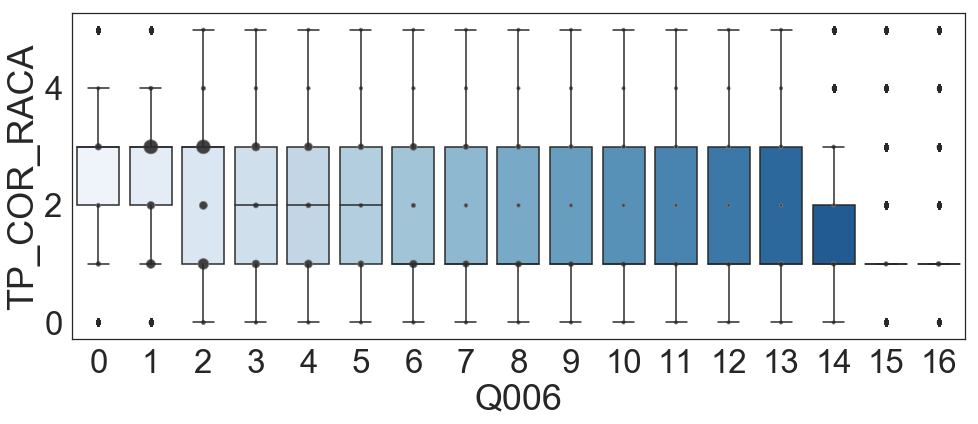

In [58]:
#Raça x Renda

plt.figure(figsize=(16, 6))
sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['TP_COR_RACA'], palette="Blues")

u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'TP_COR_RACA']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q006','TP_COR_RACA']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", legend=False)

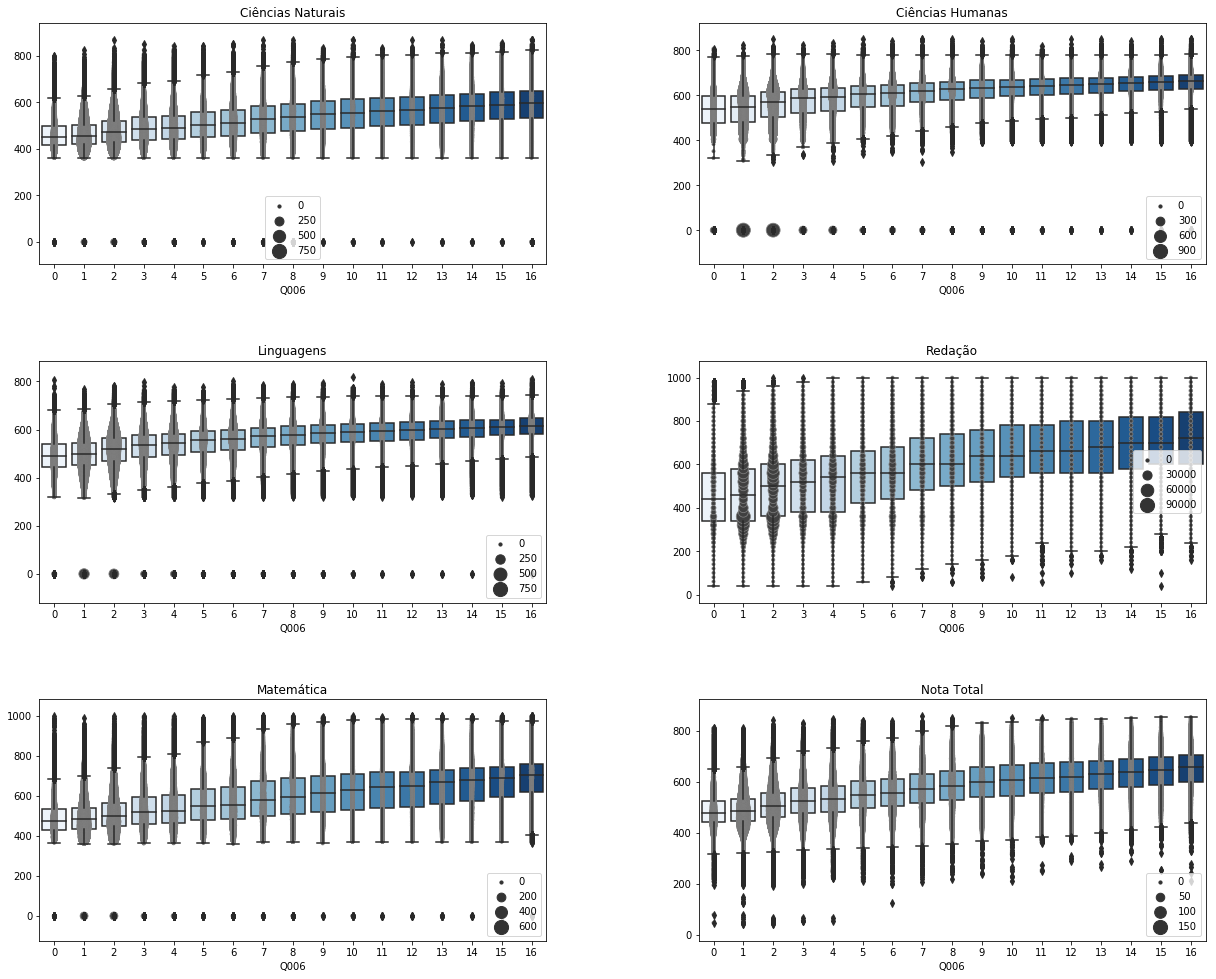

In [38]:
# RENDA

fig, axs = plt.subplots(3, 2)

# Ciências Naturais
sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_CN'], palette="Blues", ax = axs[0, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'NU_NOTA_CN']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q006','NU_NOTA_CN']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 0])

axs[0, 0].set_title('Ciências Naturais')
axs[0, 0].set(ylabel='')

# Ciências Humanas
sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_CH'], palette="Blues", ax = axs[0, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'NU_NOTA_CH']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q006','NU_NOTA_CH']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 1])

axs[0, 1].set_title('Ciências Humanas')
axs[0, 1].set(ylabel='')

# Linguagens
sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_LC'], palette="Blues", ax = axs[1, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'NU_NOTA_LC']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q006','NU_NOTA_LC']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 0])

axs[1, 0].set_title('Linguagens')
axs[1, 0].set(ylabel='')

# Redação
sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_REDACAO'], palette="Blues", ax = axs[1, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'NU_NOTA_REDACAO']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q006','NU_NOTA_REDACAO']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 1])

axs[1, 1].set_title('Redação')
axs[1, 1].set(ylabel='')

# Matemática
sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_MT'], palette="Blues", ax = axs[2, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'NU_NOTA_MT']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q006','NU_NOTA_MT']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 0])

axs[2, 0].set_title('Matemática')
axs[2, 0].set(ylabel='')

# Nota Total
sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues", ax = axs[2, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'NU_NOTA_TOTAL']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q006','NU_NOTA_TOTAL']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 1])

axs[2, 1].set_title('Nota Total')
axs[2, 1].set(ylabel='')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
fig.set_size_inches(18,15)

#BOXPLOT por renda
#0 = Nenhuma renda.
#1 = Até R$ 954,00.
#2 = De R$ 954,01 até R$ 1.431,00.
#3 = De R$ 1.431,01 até R$ 1.908,00.
#4 = De R$ 1.908,01 até R$ 2.385,00.
#5 = De R$ 2.385,01 até R$ 2.862,00.
#6 = De R$ 2.862,01 até R$ 3.816,00.
#7 = De R$ 3.816,01 até R$ 4.770,00.
#8 = De R$ 4.770,01 até R$ 5.724,00.
#9 = De R$ 5.724,01 até R$ 6.678,00.
#10 = De R$ 6.678,01 até R$ 7.632,00.
#11 = De R$ 7.632,01 até R$ 8.586,00.
#12 = De R$ 8.586,01 até R$ 9.540,00.
#13 = De R$ 9.540,01 até R$ 11.448,00.
#14 = De R$ 11.448,01 até R$ 14.310,00.
#15 = De R$ 14.310,01 até R$ 19.080,00.
#16 = Mais de R$ 19.080,00.

#sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues")

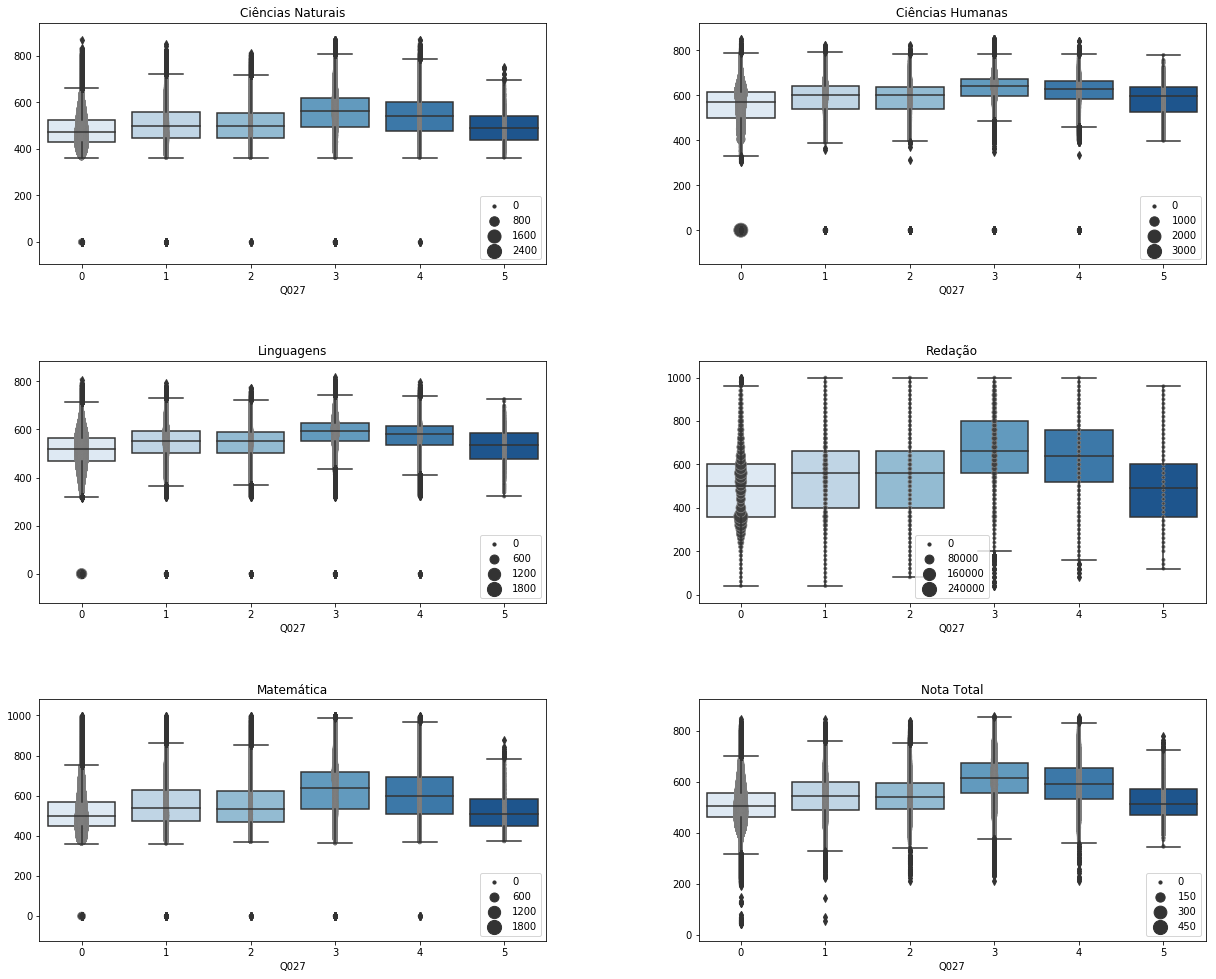

In [39]:
# ONDE CURSOU O ENSINO MÉDIO

## ordenar pela mediana - Problema da ordem
## pesquisar a opção de 'não frequentou escola'

fig, axs = plt.subplots(3, 2)

# Ciências Naturais
sns.boxplot(x=dfEnem2018['Q027'] ,y=dfEnem2018['NU_NOTA_CN'], palette="Blues", ax = axs[0, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q027', 'NU_NOTA_CN']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q027','NU_NOTA_CN']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 0])

axs[0, 0].set_title('Ciências Naturais')
axs[0, 0].set(ylabel='')

# Ciências Humanas
sns.boxplot(x=dfEnem2018['Q027'] ,y=dfEnem2018['NU_NOTA_CH'], palette="Blues", ax = axs[0, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q027', 'NU_NOTA_CH']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q027','NU_NOTA_CH']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 1])

axs[0, 1].set_title('Ciências Humanas')
axs[0, 1].set(ylabel='')

# Linguagens
sns.boxplot(x=dfEnem2018['Q027'] ,y=dfEnem2018['NU_NOTA_LC'], palette="Blues", ax = axs[1, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q027', 'NU_NOTA_LC']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q027','NU_NOTA_LC']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 0])

axs[1, 0].set_title('Linguagens')
axs[1, 0].set(ylabel='')

# Redação
sns.boxplot(x=dfEnem2018['Q027'] ,y=dfEnem2018['NU_NOTA_REDACAO'], palette="Blues", ax = axs[1, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q027', 'NU_NOTA_REDACAO']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q027','NU_NOTA_REDACAO']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 1])

axs[1, 1].set_title('Redação')
axs[1, 1].set(ylabel='')

# Matemática
sns.boxplot(x=dfEnem2018['Q027'] ,y=dfEnem2018['NU_NOTA_MT'], palette="Blues", ax = axs[2, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q027', 'NU_NOTA_MT']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q027','NU_NOTA_MT']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 0])

axs[2, 0].set_title('Matemática')
axs[2, 0].set(ylabel='')

# Nota Total
sns.boxplot(x=dfEnem2018['Q027'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues", ax = axs[2, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q027', 'NU_NOTA_TOTAL']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q027','NU_NOTA_TOTAL']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 1])

axs[2, 1].set_title('Nota Total')
axs[2, 1].set(ylabel='')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
fig.set_size_inches(18,15)

#Boxplot por tipo de escola frequentada no ensino médio
#0 = Somente em escola pública.
#1 = Parte em escola pública e parte em escola privada SEM bolsa de estudo integral.
#2 = Parte em escola pública e parte em escola privada COM bolsa de estudo integral.
#3 = Somente em escola privada SEM bolsa de estudo integral.
#4 = Somente em escola privada COM bolsa de estudo integral.
#5 = Não frequentei a escola

#sns.boxplot(x=dfEnem2018['Q027'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues")

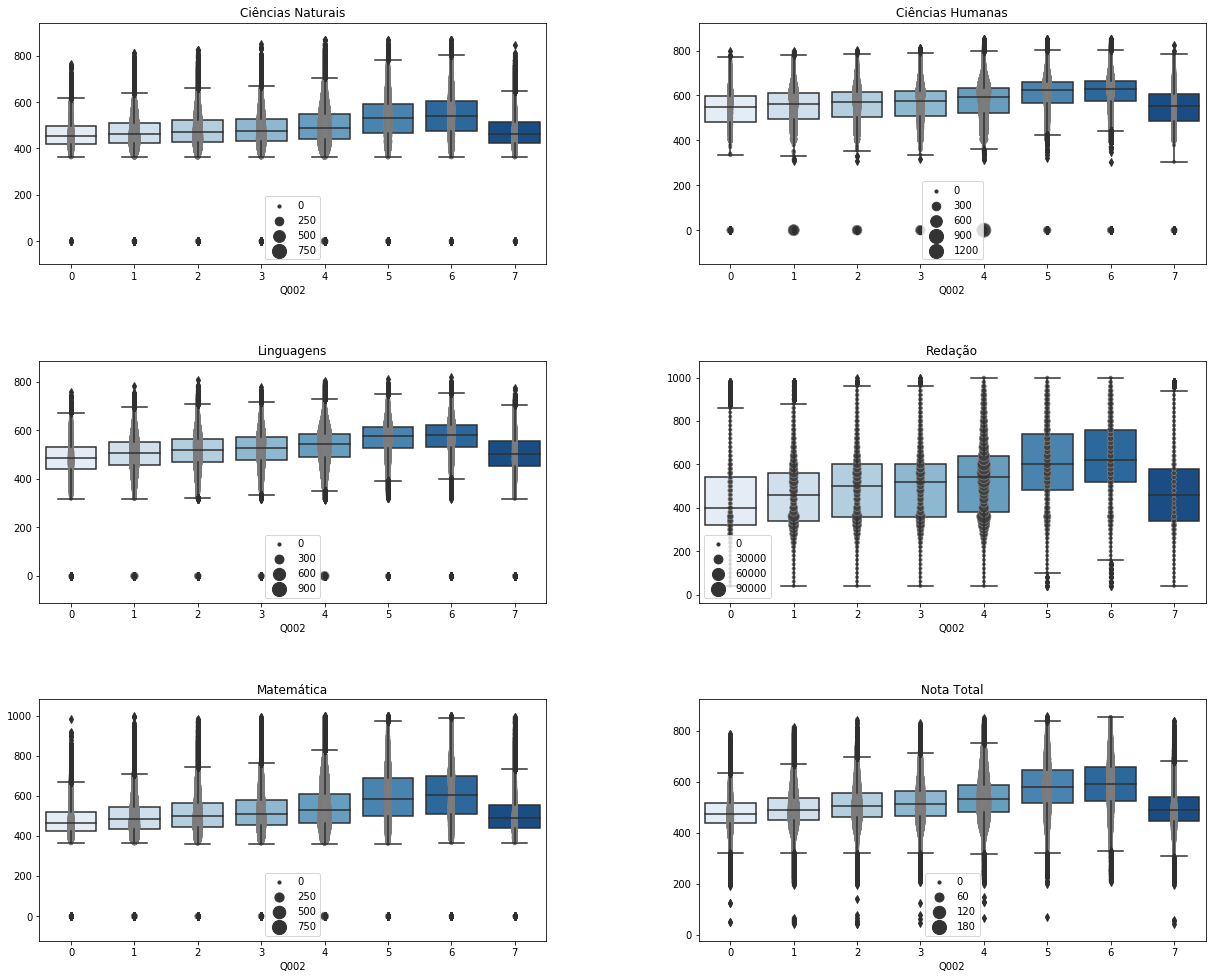

In [40]:
# Até que série sua mãe, ou a mulher responsável por você, estudou?

## ordernar o item 7 para o inicio

fig, axs = plt.subplots(3, 2)

# Ciências Naturais
sns.boxplot(x=dfEnem2018['Q002'] ,y=dfEnem2018['NU_NOTA_CN'], palette="Blues", ax = axs[0, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q002', 'NU_NOTA_CN']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q002','NU_NOTA_CN']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 0])

axs[0, 0].set_title('Ciências Naturais')
axs[0, 0].set(ylabel='')

# Ciências Humanas
sns.boxplot(x=dfEnem2018['Q002'] ,y=dfEnem2018['NU_NOTA_CH'], palette="Blues", ax = axs[0, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q002', 'NU_NOTA_CH']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q002','NU_NOTA_CH']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 1])

axs[0, 1].set_title('Ciências Humanas')
axs[0, 1].set(ylabel='')

# Linguagens
sns.boxplot(x=dfEnem2018['Q002'] ,y=dfEnem2018['NU_NOTA_LC'], palette="Blues", ax = axs[1, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q002', 'NU_NOTA_LC']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q002','NU_NOTA_LC']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 0])

axs[1, 0].set_title('Linguagens')
axs[1, 0].set(ylabel='')

# Redação
sns.boxplot(x=dfEnem2018['Q002'] ,y=dfEnem2018['NU_NOTA_REDACAO'], palette="Blues", ax = axs[1, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q002', 'NU_NOTA_REDACAO']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q002','NU_NOTA_REDACAO']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 1])

axs[1, 1].set_title('Redação')
axs[1, 1].set(ylabel='')

# Matemática
sns.boxplot(x=dfEnem2018['Q002'] ,y=dfEnem2018['NU_NOTA_MT'], palette="Blues", ax = axs[2, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q002', 'NU_NOTA_MT']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q002','NU_NOTA_MT']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 0])

axs[2, 0].set_title('Matemática')
axs[2, 0].set(ylabel='')

# Nota Total
sns.boxplot(x=dfEnem2018['Q002'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues", ax = axs[2, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q002', 'NU_NOTA_TOTAL']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q002','NU_NOTA_TOTAL']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 1])

axs[2, 1].set_title('Nota Total')
axs[2, 1].set(ylabel='')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
fig.set_size_inches(18,15)

#Boxplot por gradução da mãe
#0 = Nunca estudou.
#1 = Não completou a 4ª série/5º ano do Ensino Fundamental.
#2 = Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.
#3 = Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.
#4 = Completou o Ensino Médio, mas não completou a Faculdade.
#5 = Completou a Faculdade, mas não completou a Pós-graduação.
#6 = Completou a Pós-graduação.
#7 = Não sei.

#sns.boxplot(x=dfEnem2018['Q002'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues")

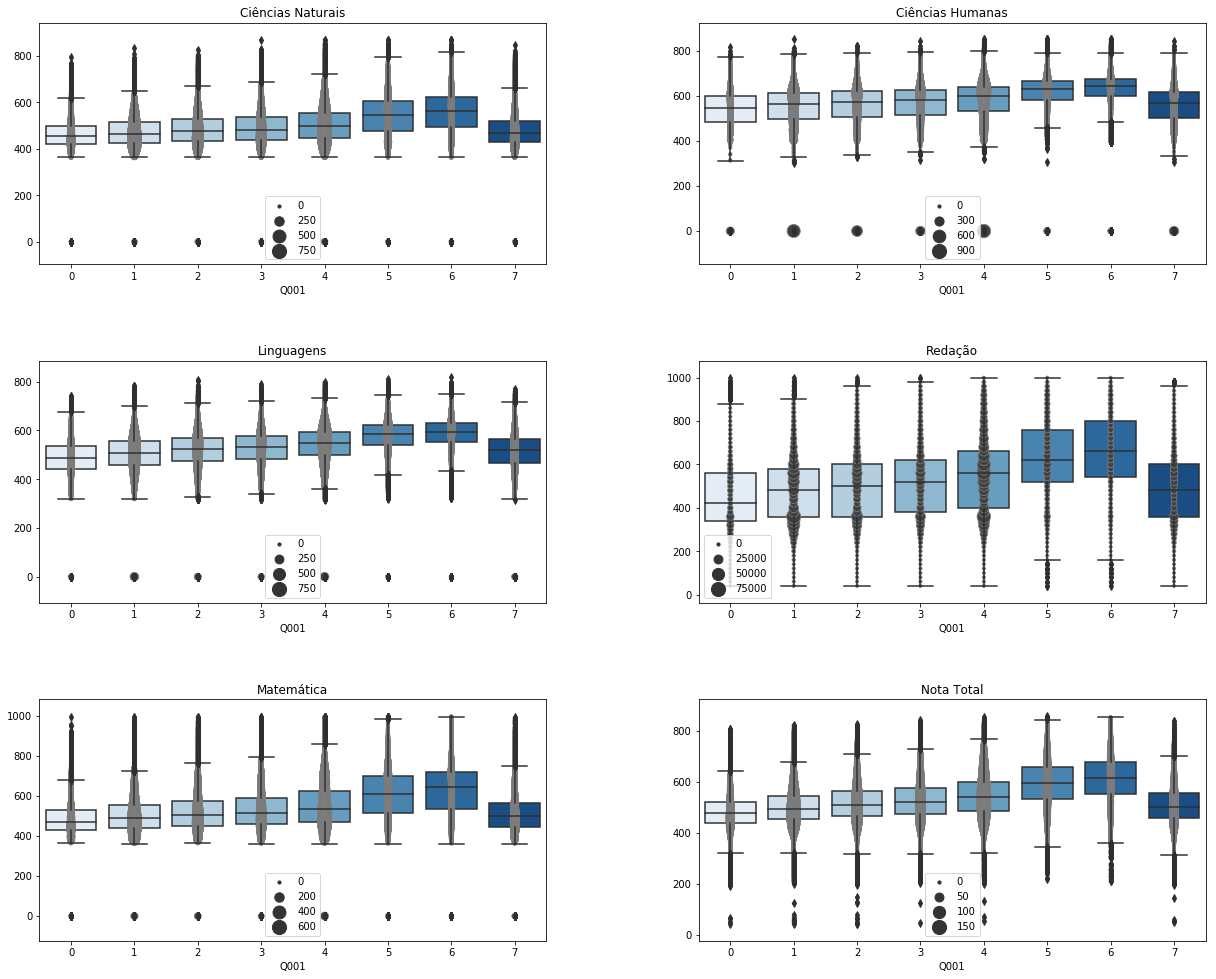

In [41]:
## gerar o gráfico pela escolaridade do pai (Q001)

## ordernar o item 7 para o inicio

fig, axs = plt.subplots(3, 2)

# Ciências Naturais
sns.boxplot(x=dfEnem2018['Q001'] ,y=dfEnem2018['NU_NOTA_CN'], palette="Blues", ax = axs[0, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q001', 'NU_NOTA_CN']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q001','NU_NOTA_CN']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 0])

axs[0, 0].set_title('Ciências Naturais')
axs[0, 0].set(ylabel='')

# Ciências Humanas
sns.boxplot(x=dfEnem2018['Q001'] ,y=dfEnem2018['NU_NOTA_CH'], palette="Blues", ax = axs[0, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q001', 'NU_NOTA_CH']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q001','NU_NOTA_CH']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0, 1])

axs[0, 1].set_title('Ciências Humanas')
axs[0, 1].set(ylabel='')

# Linguagens
sns.boxplot(x=dfEnem2018['Q001'] ,y=dfEnem2018['NU_NOTA_LC'], palette="Blues", ax = axs[1, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q001', 'NU_NOTA_LC']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q001','NU_NOTA_LC']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 0])

axs[1, 0].set_title('Linguagens')
axs[1, 0].set(ylabel='')

# Redação
sns.boxplot(x=dfEnem2018['Q001'] ,y=dfEnem2018['NU_NOTA_REDACAO'], palette="Blues", ax = axs[1, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q001', 'NU_NOTA_REDACAO']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q001','NU_NOTA_REDACAO']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[1, 1])

axs[1, 1].set_title('Redação')
axs[1, 1].set(ylabel='')

# Matemática
sns.boxplot(x=dfEnem2018['Q001'] ,y=dfEnem2018['NU_NOTA_MT'], palette="Blues", ax = axs[2, 0])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q001', 'NU_NOTA_MT']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q001','NU_NOTA_MT']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 0])

axs[2, 0].set_title('Matemática')
axs[2, 0].set(ylabel='')

# Nota Total
sns.boxplot(x=dfEnem2018['Q001'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues", ax = axs[2, 1])

u = np.asarray(list(dict(dfEnem2018.groupby(['Q001', 'NU_NOTA_TOTAL']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q001','NU_NOTA_TOTAL']).size()).values())
sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[2, 1])

axs[2, 1].set_title('Nota Total')
axs[2, 1].set(ylabel='')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
fig.set_size_inches(18,15)

#Boxplot por gradução do pai
#0 = Nunca estudou.
#1 = Não completou a 4ª série/5º ano do Ensino Fundamental.
#2 = Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.
#3 = Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.
#4 = Completou o Ensino Médio, mas não completou a Faculdade.
#5 = Completou a Faculdade, mas não completou a Pós-graduação.
#6 = Completou a Pós-graduação.
#7 = Não sei.

#sns.boxplot(x=dfEnem2018['Q001'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues")

<h2>Aplicação da detecção de outlier</h2>

In [4]:
#Aplicando o isolation forest

#Mantendo somente as variaveis Q002, Q006, RACA, Q027 + Notas
clf = IsolationForest(n_estimators=10)
clf.fit(dfEnem2018.drop(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'Q001', 'Q003',
       'Q004', 'Q005', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
       'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
       'Q022', 'Q023', 'Q024', 'Q025', 'Q026'],axis=1))
dfEnem2018['Resultado_Outlier_Todas'] = clf.predict(dfEnem2018.drop(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'Q001', 'Q003',
       'Q004', 'Q005', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
       'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
       'Q022', 'Q023', 'Q024', 'Q025', 'Q026'],axis=1))

#Q002 + NOTA
clf = IsolationForest(n_estimators=10)
clf.fit(dfEnem2018[['NU_NOTA_TOTAL', 'Q002']])
dfEnem2018['Resultado_Outlier_Q002'] = clf.predict(dfEnem2018[['NU_NOTA_TOTAL', 'Q002']])

#Q006 + NOTA
clf = IsolationForest(n_estimators=10)
clf.fit(dfEnem2018[['NU_NOTA_TOTAL', 'Q006']])
dfEnem2018['Resultado_Outlier_Q006'] = clf.predict(dfEnem2018[['NU_NOTA_TOTAL', 'Q006']])

#Q027 + NOTA
clf = IsolationForest(n_estimators=10)
clf.fit(dfEnem2018[['NU_NOTA_TOTAL', 'Q027']])
dfEnem2018['Resultado_Outlier_Q027'] = clf.predict(dfEnem2018[['NU_NOTA_TOTAL', 'Q027']])

#Raça + NOTA
clf = IsolationForest(n_estimators=10)
clf.fit(dfEnem2018[['NU_NOTA_TOTAL', 'TP_COR_RACA']])
dfEnem2018['Resultado_Outlier_RACA'] = clf.predict(dfEnem2018[['NU_NOTA_TOTAL', 'TP_COR_RACA']])

#SOMENTE Q006
clf = IsolationForest(n_estimators=10)
clf.fit(dfEnem2018[['Q006']])
dfEnem2018['Resultado_Outlier_Q006_2'] = clf.predict(dfEnem2018[['Q006']])

#SOMENTE NOTA
clf = IsolationForest(n_estimators=10)
clf.fit(dfEnem2018[['NU_NOTA_TOTAL']])
dfEnem2018['Resultado_Outlier_NOTA'] = clf.predict(dfEnem2018[['NU_NOTA_TOTAL']])

dfEnem2018['Resultado_Outlier_Q006'] = dfEnem2018['Resultado_Outlier_Q006'].map({-1: 'Outlier', 1: 'Inlier'})
dfEnem2018['Resultado_Outlier_Q006_2'] = dfEnem2018['Resultado_Outlier_Q006_2'].map({-1: 'Outlier', 1: 'Inlier'})
dfEnem2018['Resultado_Outlier_Q002'] = dfEnem2018['Resultado_Outlier_Q002'].map({-1: 'Outlier', 1: 'Inlier'})
dfEnem2018['Resultado_Outlier_Q027'] = dfEnem2018['Resultado_Outlier_Q027'].map({-1: 'Outlier', 1: 'Inlier'})
dfEnem2018['Resultado_Outlier_RACA'] = dfEnem2018['Resultado_Outlier_RACA'].map({-1: 'Outlier', 1: 'Inlier'})
dfEnem2018['Resultado_Outlier_NOTA'] = dfEnem2018['Resultado_Outlier_NOTA'].map({-1: 'Outlier', 1: 'Inlier'})

Abaixo um histograma utilizando o IsolationForest com todas as variáveis do escopo sócio-econômico

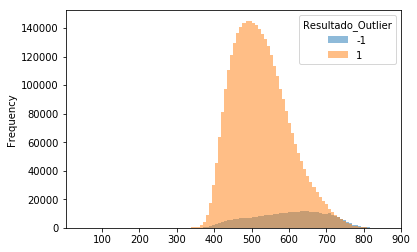

In [9]:
dfEnem2018.pivot(columns='Resultado_Outlier', values='NU_NOTA_TOTAL').plot.hist(bins=100, alpha = 0.5)

Abaixo histograma do IsolationForest com as variáveis Q002, Q006, Q027, Raça e Todas as notas

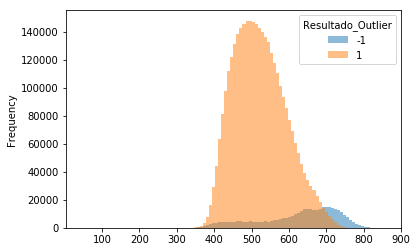

In [5]:
dfEnem2018.pivot(columns='Resultado_Outlier', values='NU_NOTA_TOTAL').plot.hist(bins=100, alpha = 0.5)

Abaixo histograma somente das notas

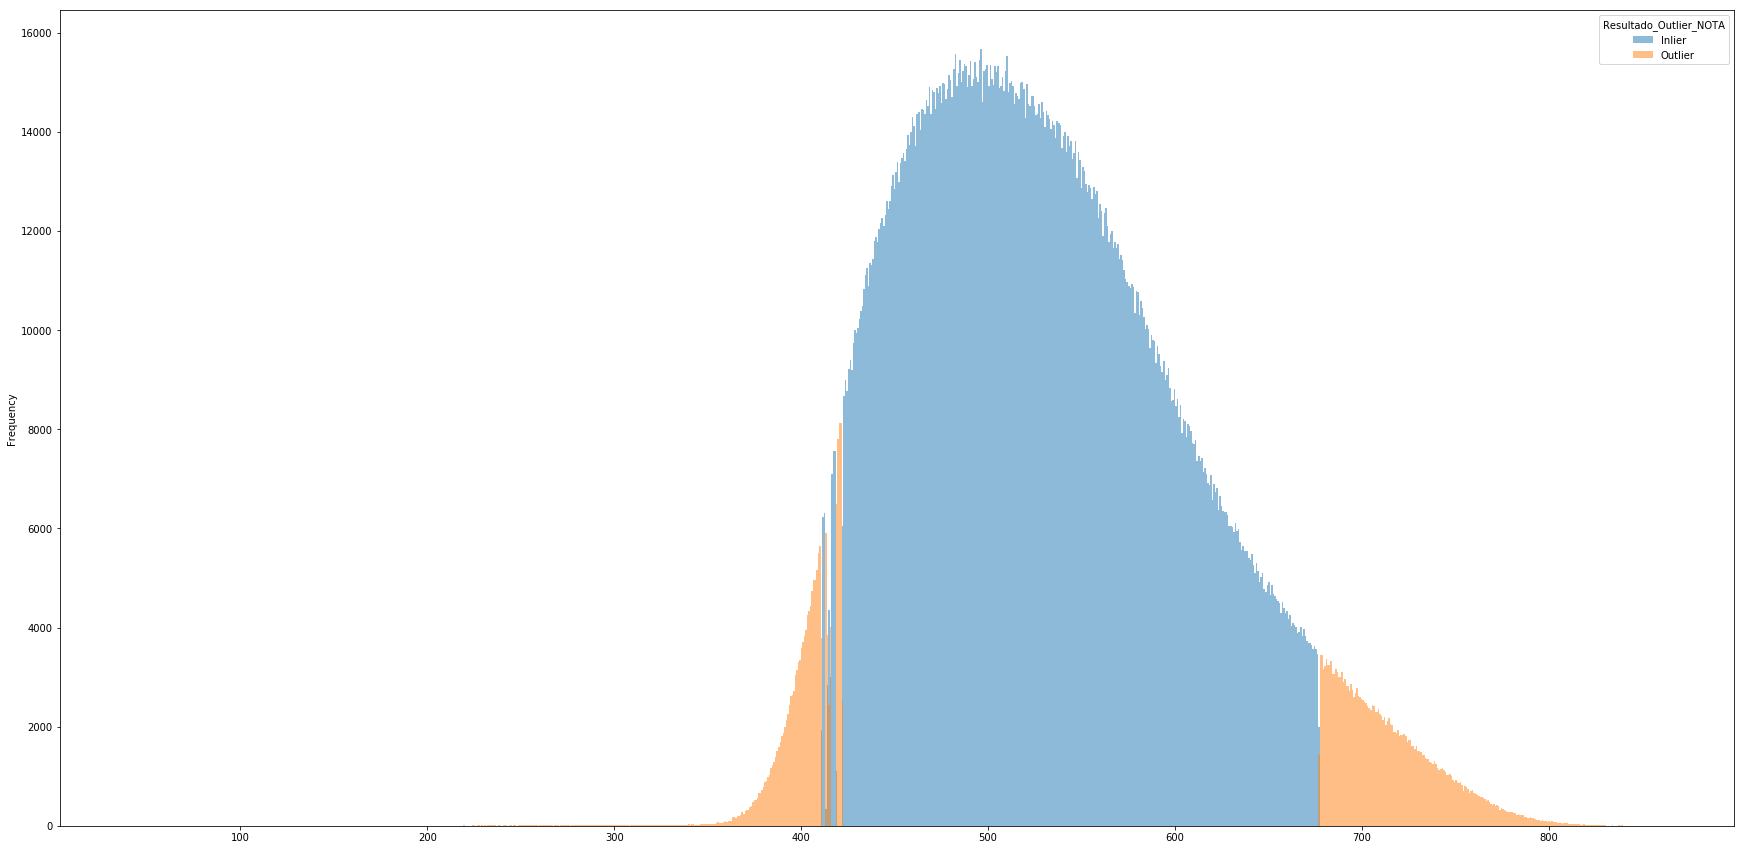

In [9]:
fig = plt.figure(figsize=(30, 15))
ax = fig.gca()
dfEnem2018.pivot(columns='Resultado_Outlier_NOTA', values='NU_NOTA_TOTAL').plot.hist(bins=1000, alpha = 0.5, ax = ax)

<h2>Aplicando o Ridgeplot para avaliação das variáveis mais importantes</h2>

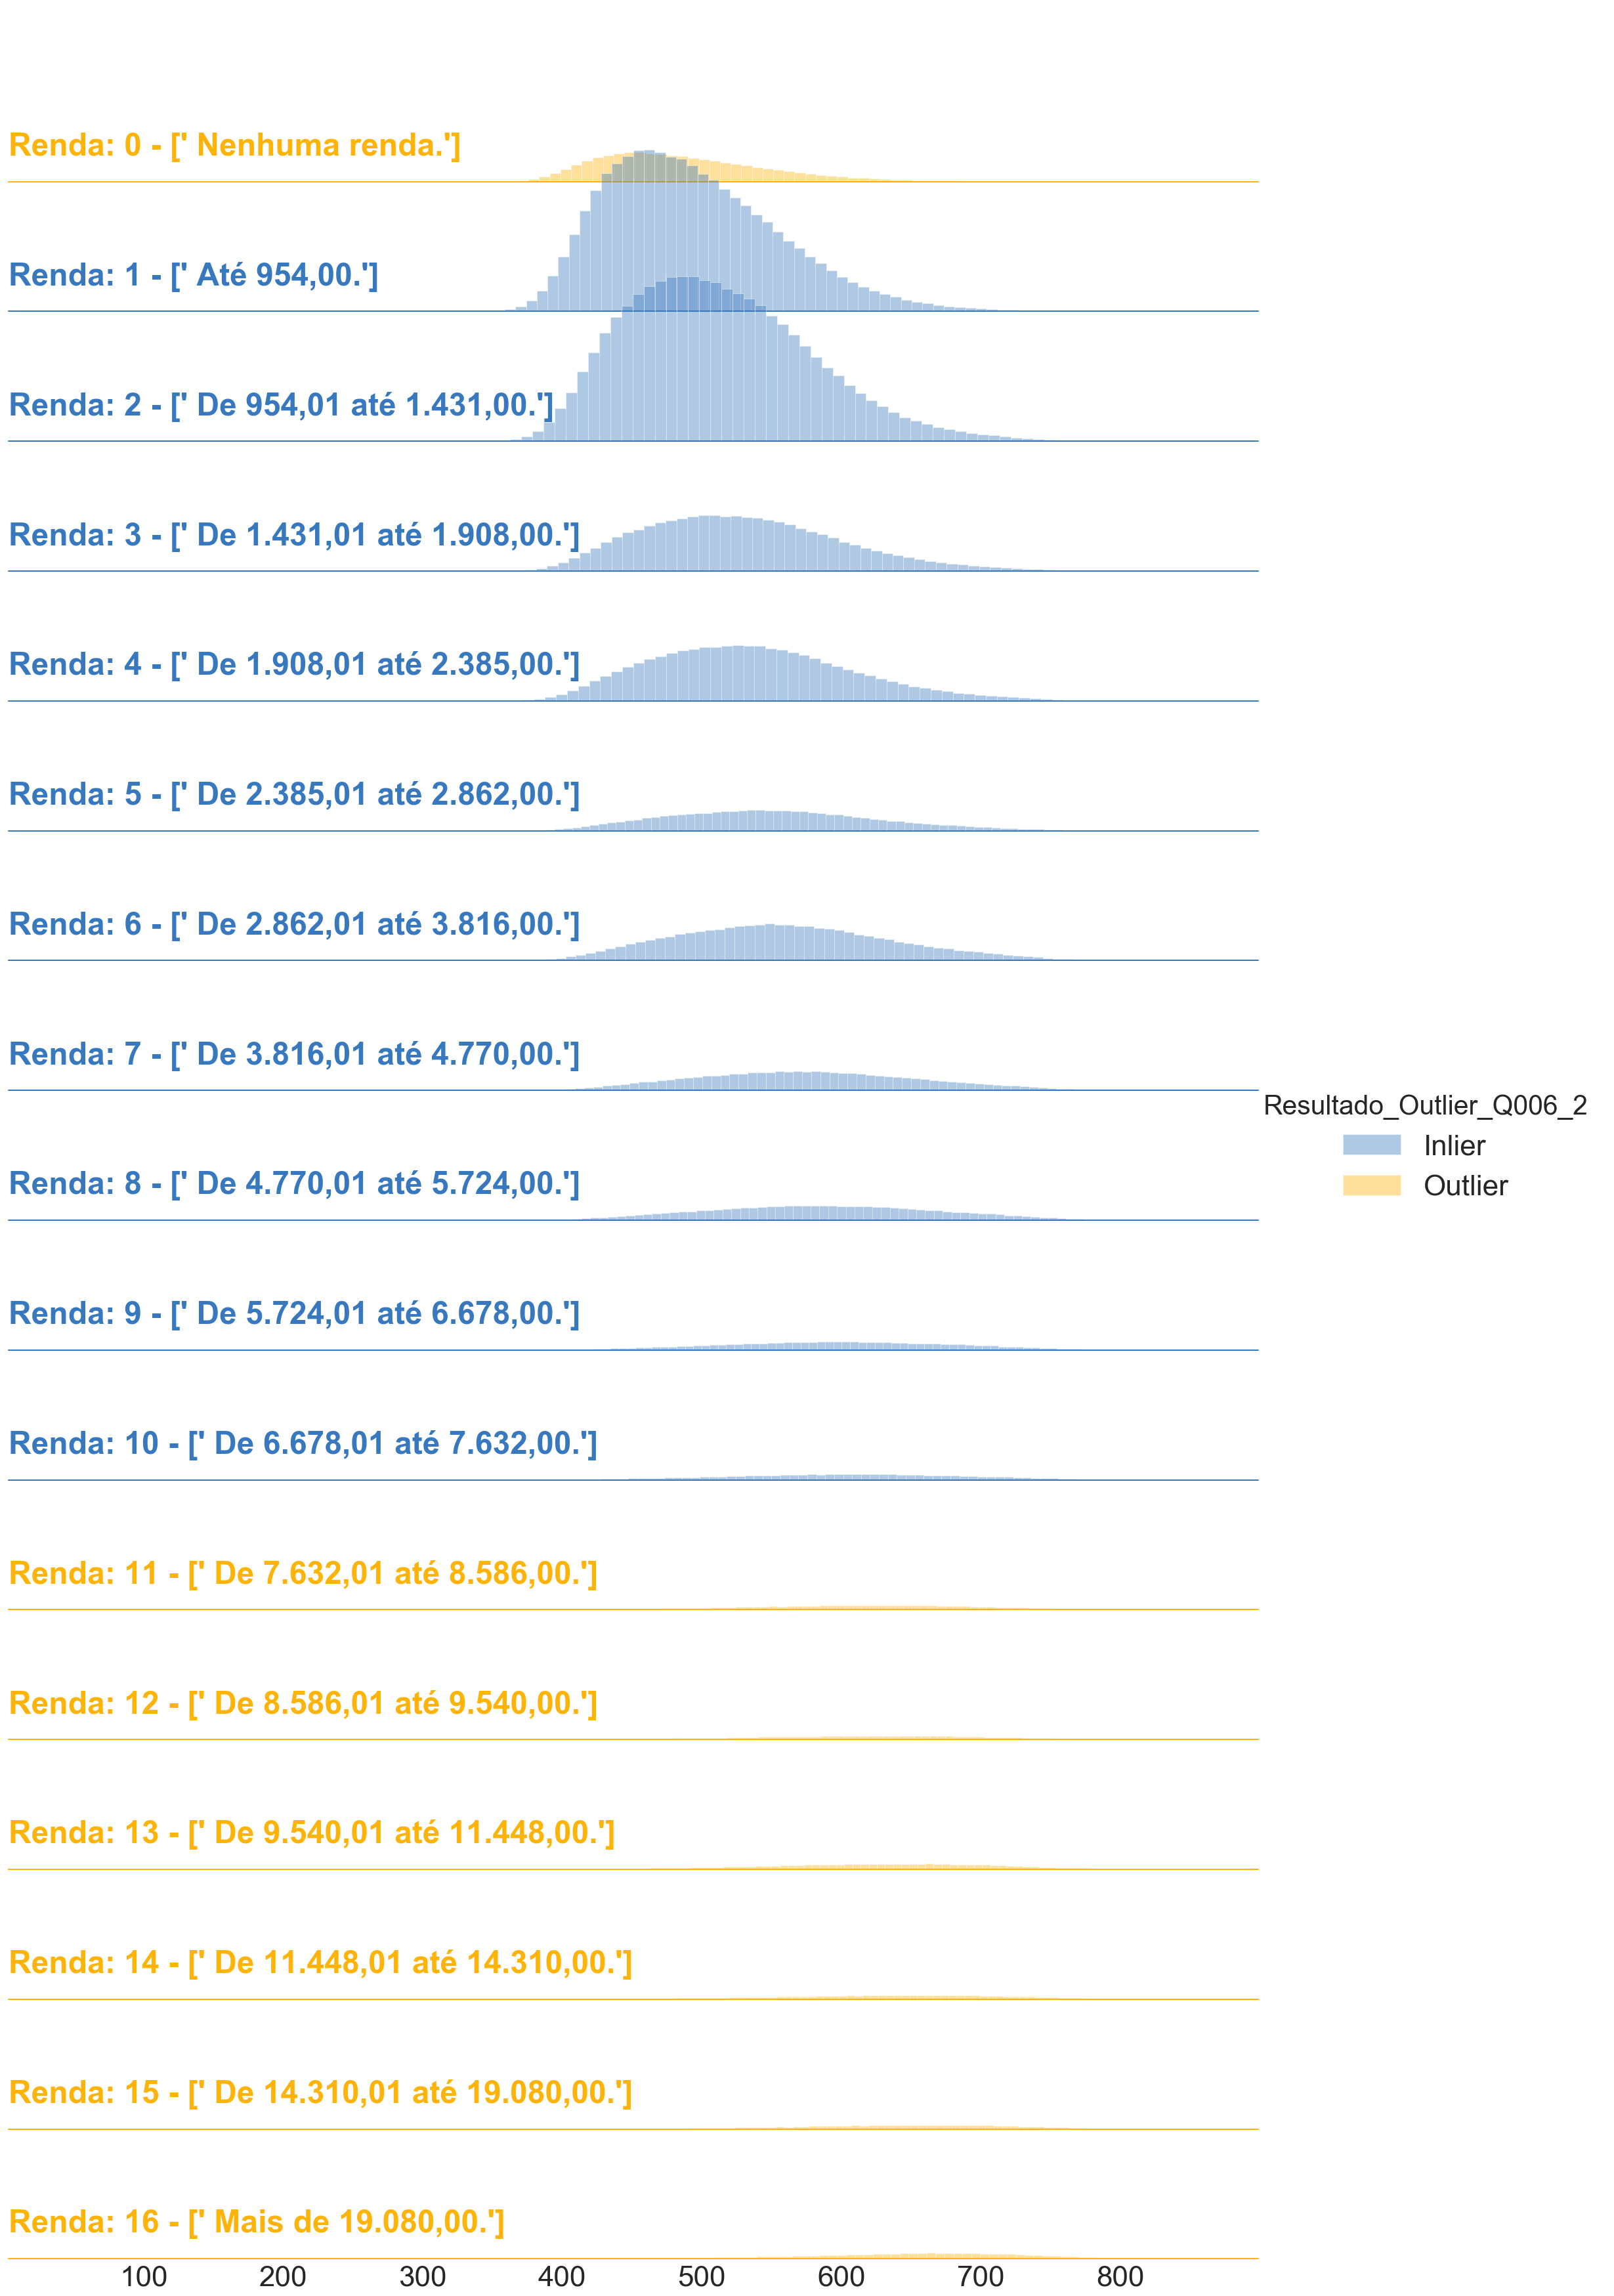

In [8]:
# RENDA com Oulier
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=4)

colors = ["windows blue", "amber"]
pal = sns.xkcd_palette(colors)

# Initialize the FacetGrid object
g = sns.FacetGrid(dfEnem2018, row="Q006", hue="Resultado_Outlier_Q006_2", palette=pal, aspect=10)

# Draw the densities in a few steps
g.map(sns.distplot, "NU_NOTA_TOTAL", hist=True, kde=False, bins=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    if dfEnem2018.loc[x.index[0],'Resultado_Outlier_Q006_2'] == 'Inlier':
        ax.text(0, .2, 'Renda: ' + str(dfEnem2018.loc[x.index[0],'Q006']) + ' - ' + str(resp.loc[lambda y: (resp.Pergunta == 'Q006') & (resp.Opção == dfEnem2018.loc[x.index[0],'Q006']),'Resposta'].values), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    if dfEnem2018.loc[x.index[0],'Resultado_Outlier_Q006_2'] == 'Outlier':
        ax.text(0, .2, 'Renda: ' + str(dfEnem2018.loc[x.index[0],'Q006']) + ' - ' + str(resp.loc[lambda y: (resp.Pergunta == 'Q006') & (resp.Opção == dfEnem2018.loc[x.index[0],'Q006']),'Resposta'].values), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

g.map(label, "NU_NOTA_TOTAL")
g.add_legend()


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.set(xlabel='')

#for value in sorted(dfEnem2018.Q006.unique()):
#    g.axes[value,0].set_xlabel(value, position = (.01,2))

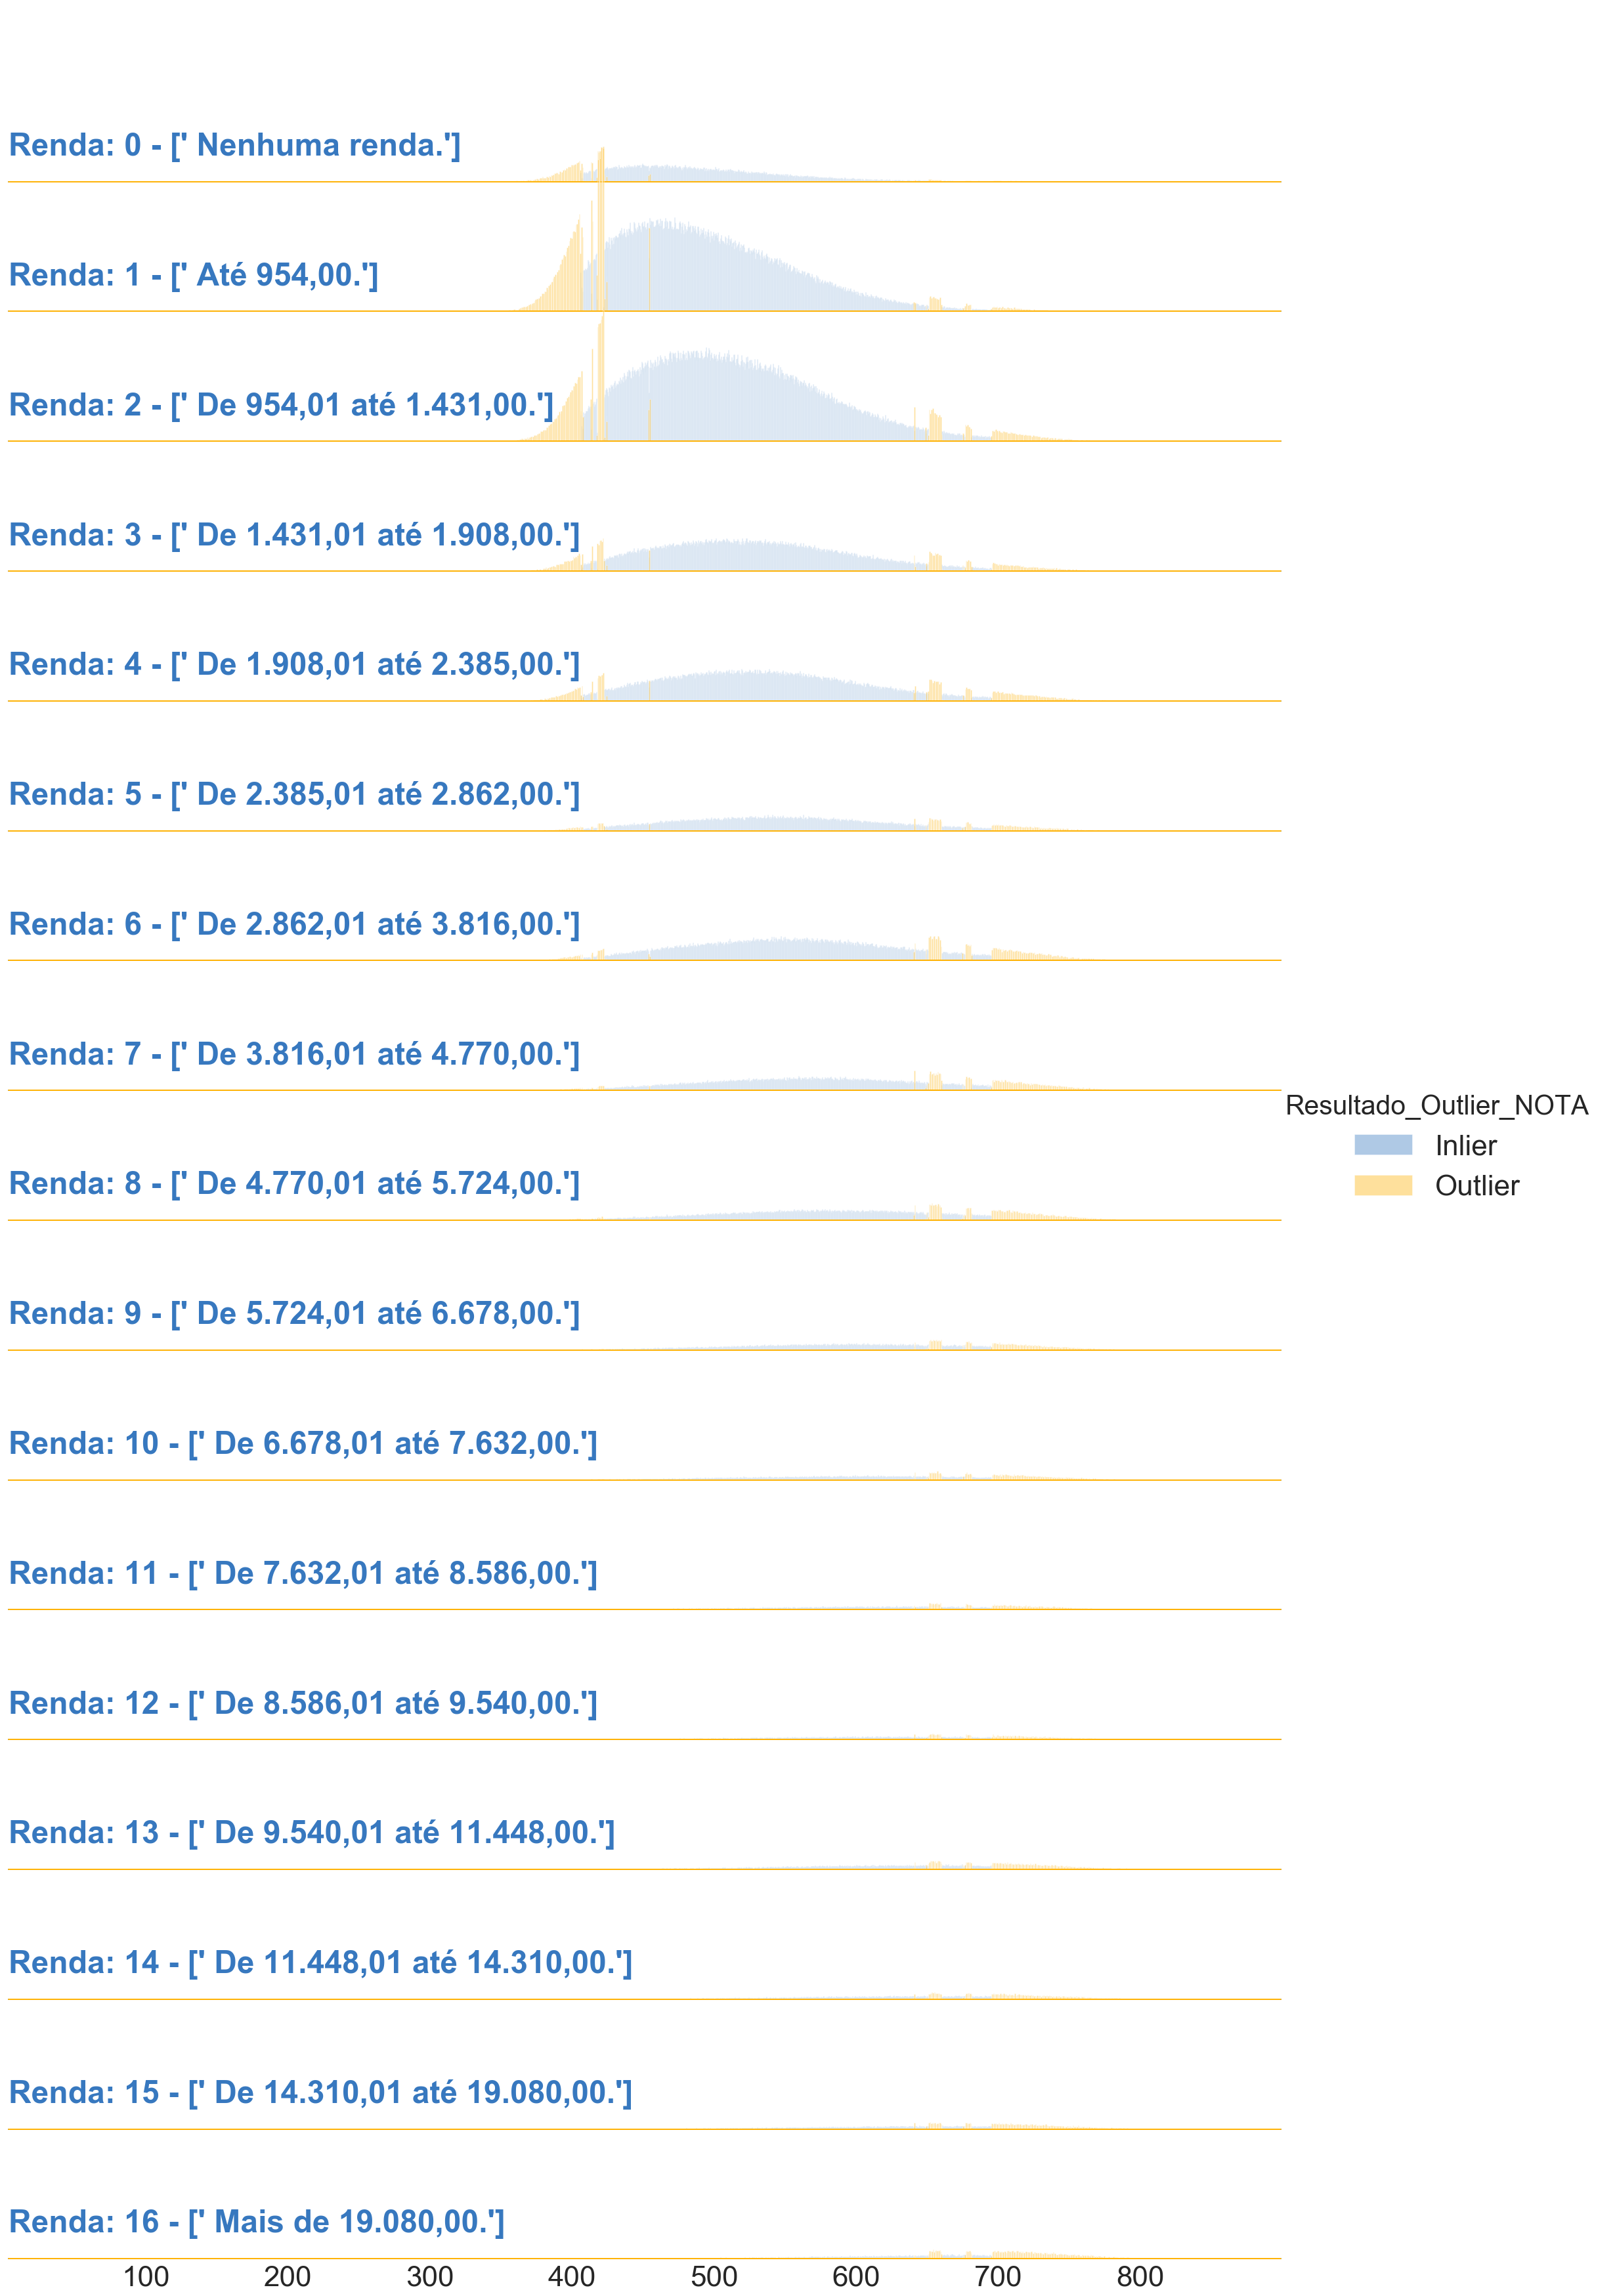

In [10]:
# RENDA com Oulier
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=4)

colors = ["windows blue", "amber"]
pal = sns.xkcd_palette(colors)

# Initialize the FacetGrid object
g = sns.FacetGrid(dfEnem2018, row="Q006", hue="Resultado_Outlier_NOTA", palette=pal, aspect=10)

# Draw the densities in a few steps
g.map(sns.distplot, "NU_NOTA_TOTAL", hist=True, kde=False, bins=1000)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    if dfEnem2018.loc[x.index[0],'Resultado_Outlier_NOTA'] == 'Inlier':
        ax.text(0, .2, 'Renda: ' + str(dfEnem2018.loc[x.index[0],'Q006']) + ' - ' + str(resp.loc[lambda y: (resp.Pergunta == 'Q006') & (resp.Opção == dfEnem2018.loc[x.index[0],'Q006']),'Resposta'].values), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

g.map(label, "NU_NOTA_TOTAL")
g.add_legend()


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.set(xlabel='')

#for value in sorted(dfEnem2018.Q006.unique()):
#    g.axes[value,0].set_xlabel(value, position = (.01,2))

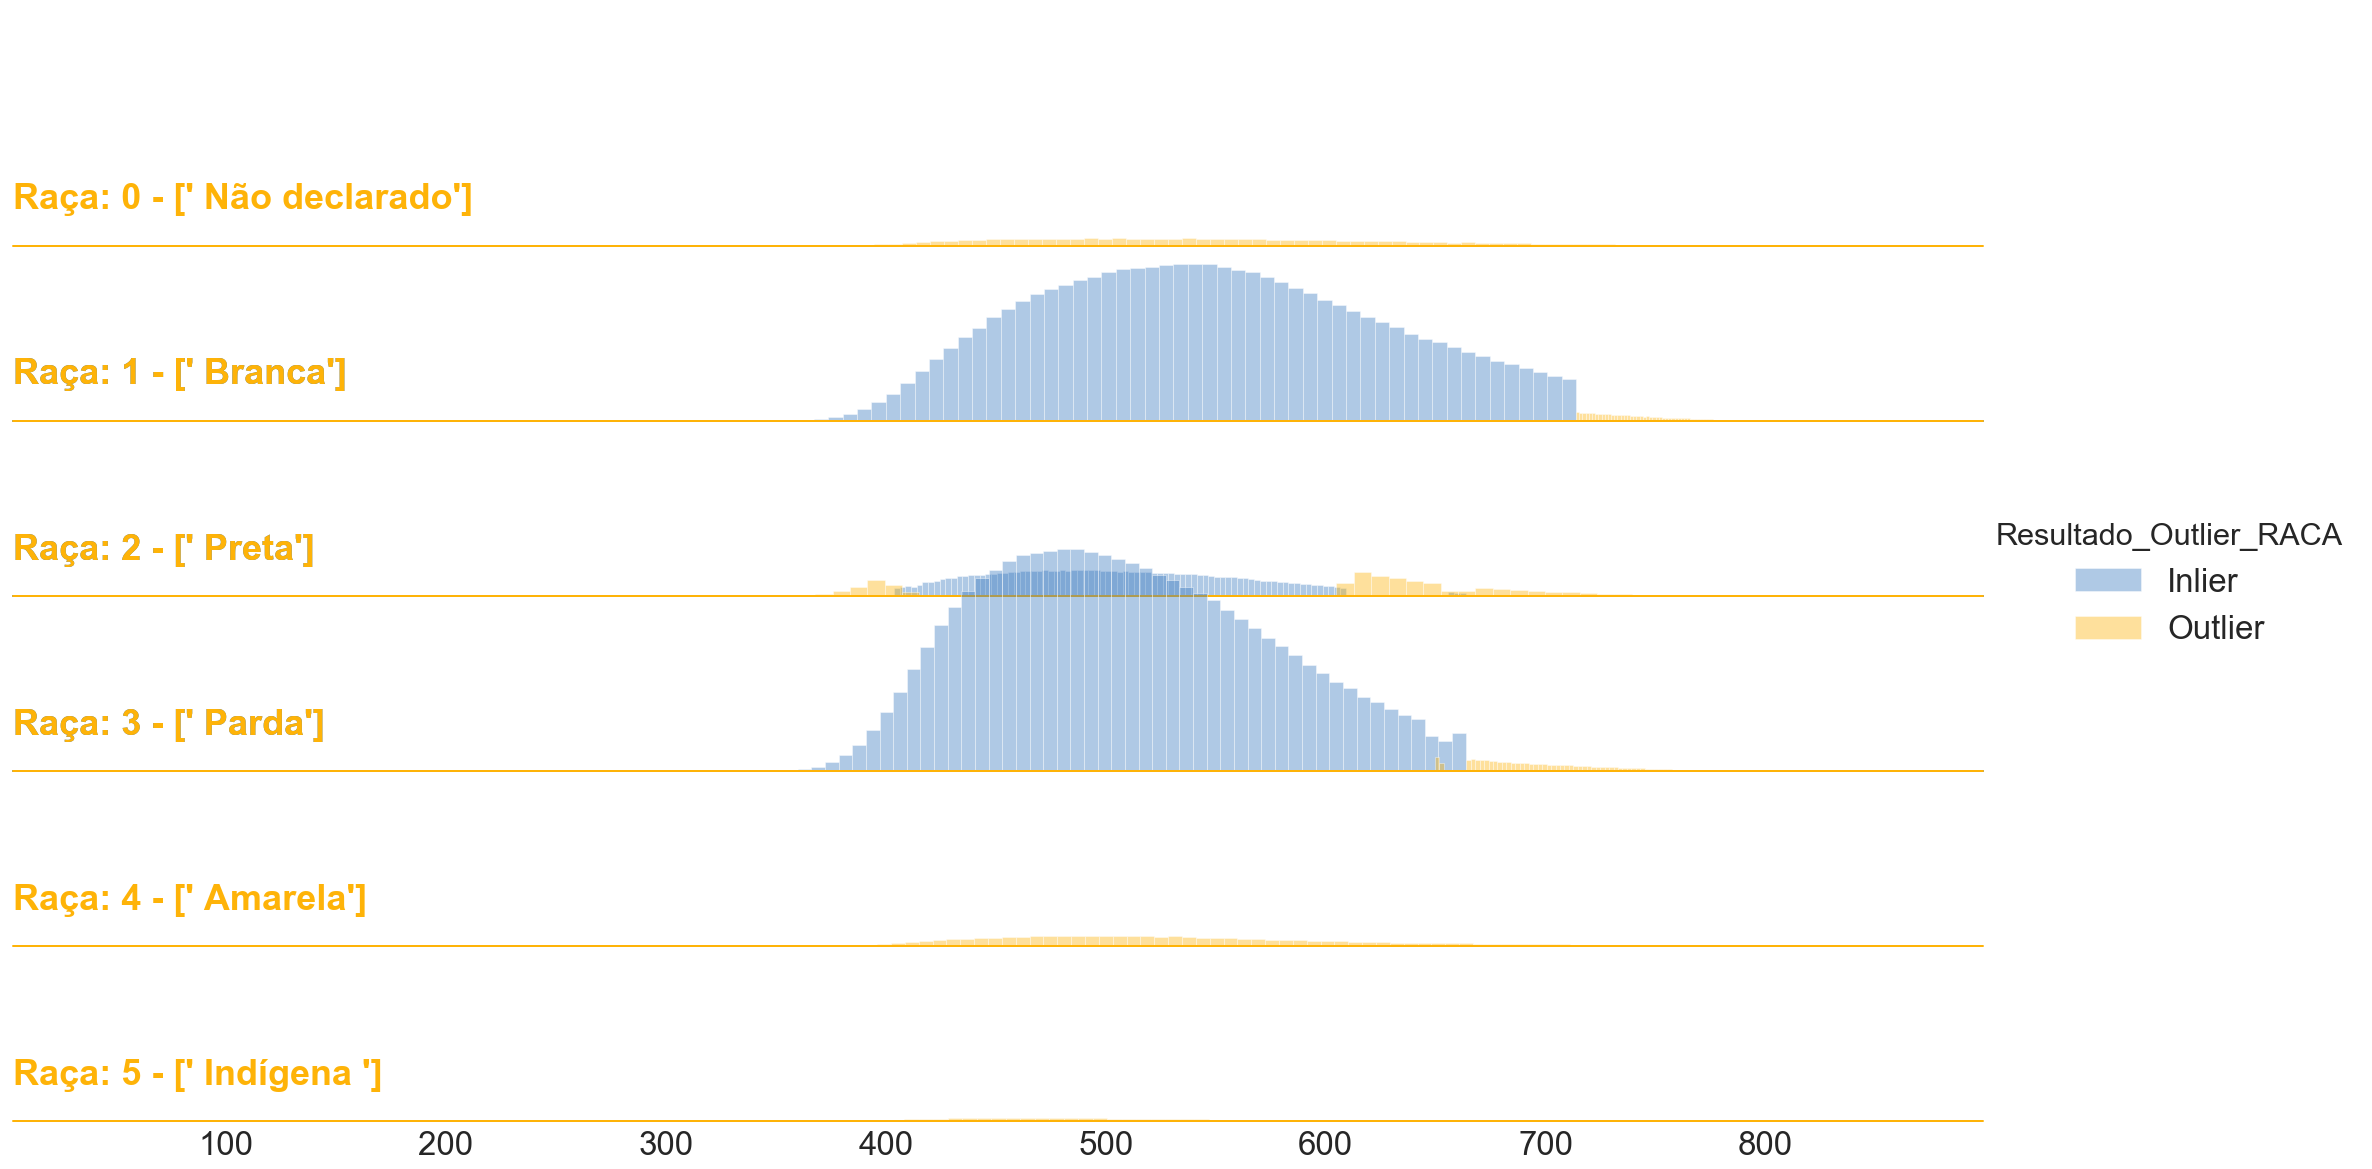

In [12]:
# Raça com Oulier
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=3)

colors = ["windows blue", "amber"]
pal = sns.xkcd_palette(colors)

# Initialize the FacetGrid object
g = sns.FacetGrid(dfEnem2018, row="TP_COR_RACA", hue="Resultado_Outlier_RACA", palette=pal, aspect=10)

# Draw the densities in a few steps
g.map(sns.distplot, "NU_NOTA_TOTAL", hist=True, kde=False, bins=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    if dfEnem2018.loc[x.index[0],'Resultado_Outlier_RACA'] == 'Inlier':
        ax.text(0, .2, 'Raça: ' + str(dfEnem2018.loc[x.index[0],'TP_COR_RACA']) + ' - ' + str(resp.loc[lambda y: (resp.Pergunta == 'TP_COR_RACA') & (resp.Opção == dfEnem2018.loc[x.index[0],'TP_COR_RACA']),'Resposta'].values), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    if dfEnem2018.loc[x.index[0],'Resultado_Outlier_RACA'] == 'Outlier':
        ax.text(0, .2, 'Raça: ' + str(dfEnem2018.loc[x.index[0],'TP_COR_RACA']) + ' - ' + str(resp.loc[lambda y: (resp.Pergunta == 'TP_COR_RACA') & (resp.Opção == dfEnem2018.loc[x.index[0],'TP_COR_RACA']),'Resposta'].values), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

g.map(label, "NU_NOTA_TOTAL")
g.add_legend()


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.set(xlabel='')

#for value in sorted(dfEnem2018.Q006.unique()):
#    g.axes[value,0].set_xlabel(value, position = (.01,2))

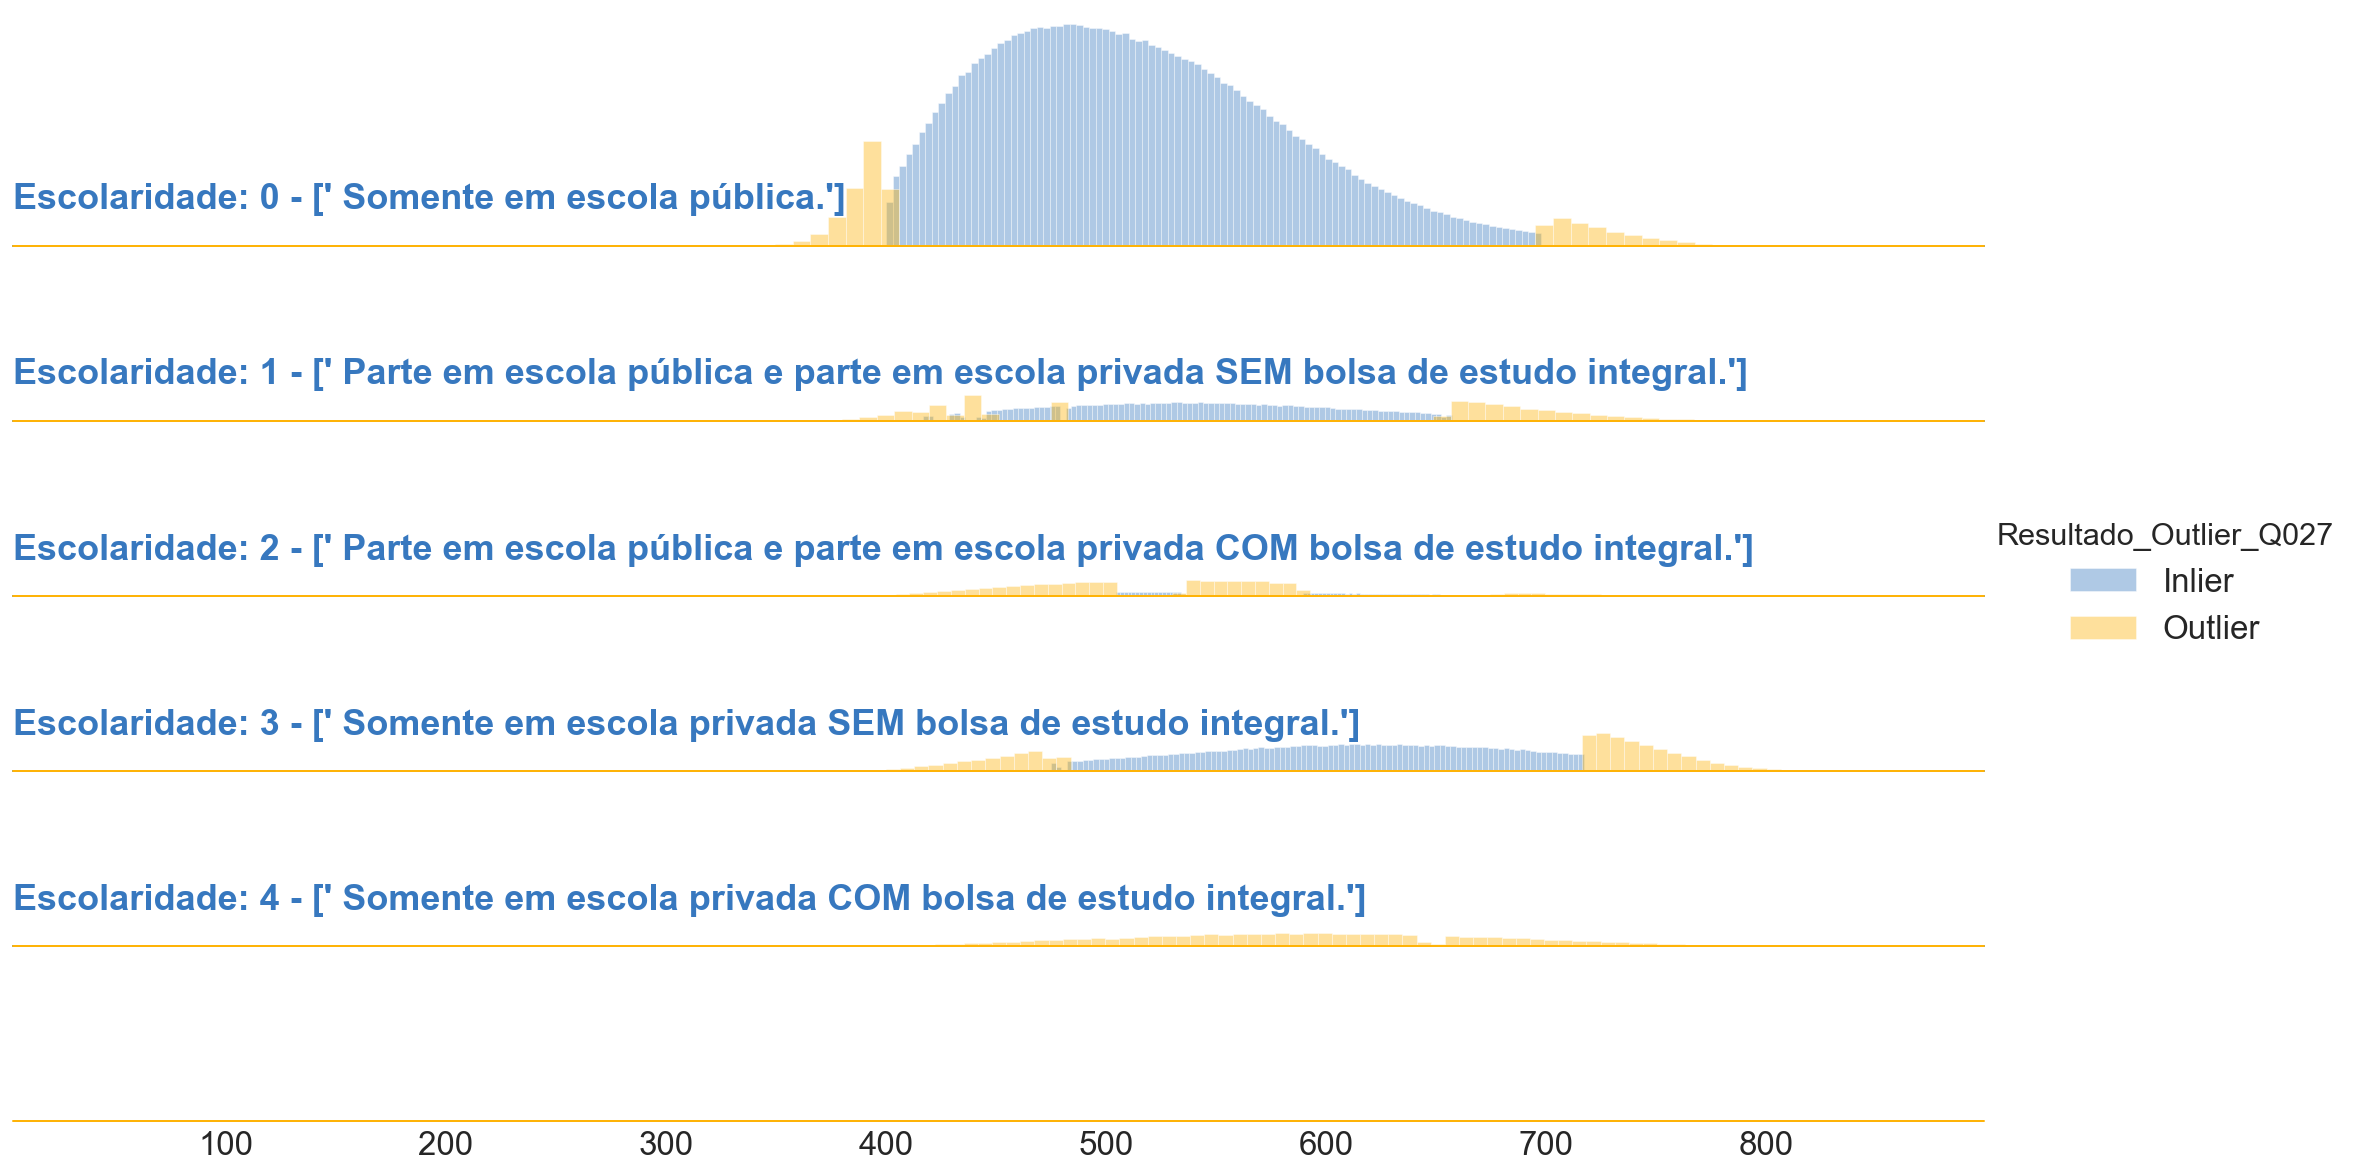

In [14]:
# Escolaridade com Oulier
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=3)

colors = ["windows blue", "amber"]
pal = sns.xkcd_palette(colors)

# Initialize the FacetGrid object
g = sns.FacetGrid(dfEnem2018, row="Q027", hue="Resultado_Outlier_Q027", palette=pal, aspect=10)

# Draw the densities in a few steps
g.map(sns.distplot, "NU_NOTA_TOTAL", hist=True, kde=False, bins=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    if dfEnem2018.loc[x.index[0],'Resultado_Outlier_Q027'] == 'Inlier':
        ax.text(0, .2, 'Escolaridade: ' + str(dfEnem2018.loc[x.index[0],'Q027']) + ' - ' + str(resp.loc[lambda y: (resp.Pergunta == 'Q027') & (resp.Opção == dfEnem2018.loc[x.index[0],'Q027']),'Resposta'].values), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

g.map(label, "NU_NOTA_TOTAL")
g.add_legend()


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.set(xlabel='')

#for value in sorted(dfEnem2018.Q006.unique()):
#    g.axes[value,0].set_xlabel(value, position = (.01,2))

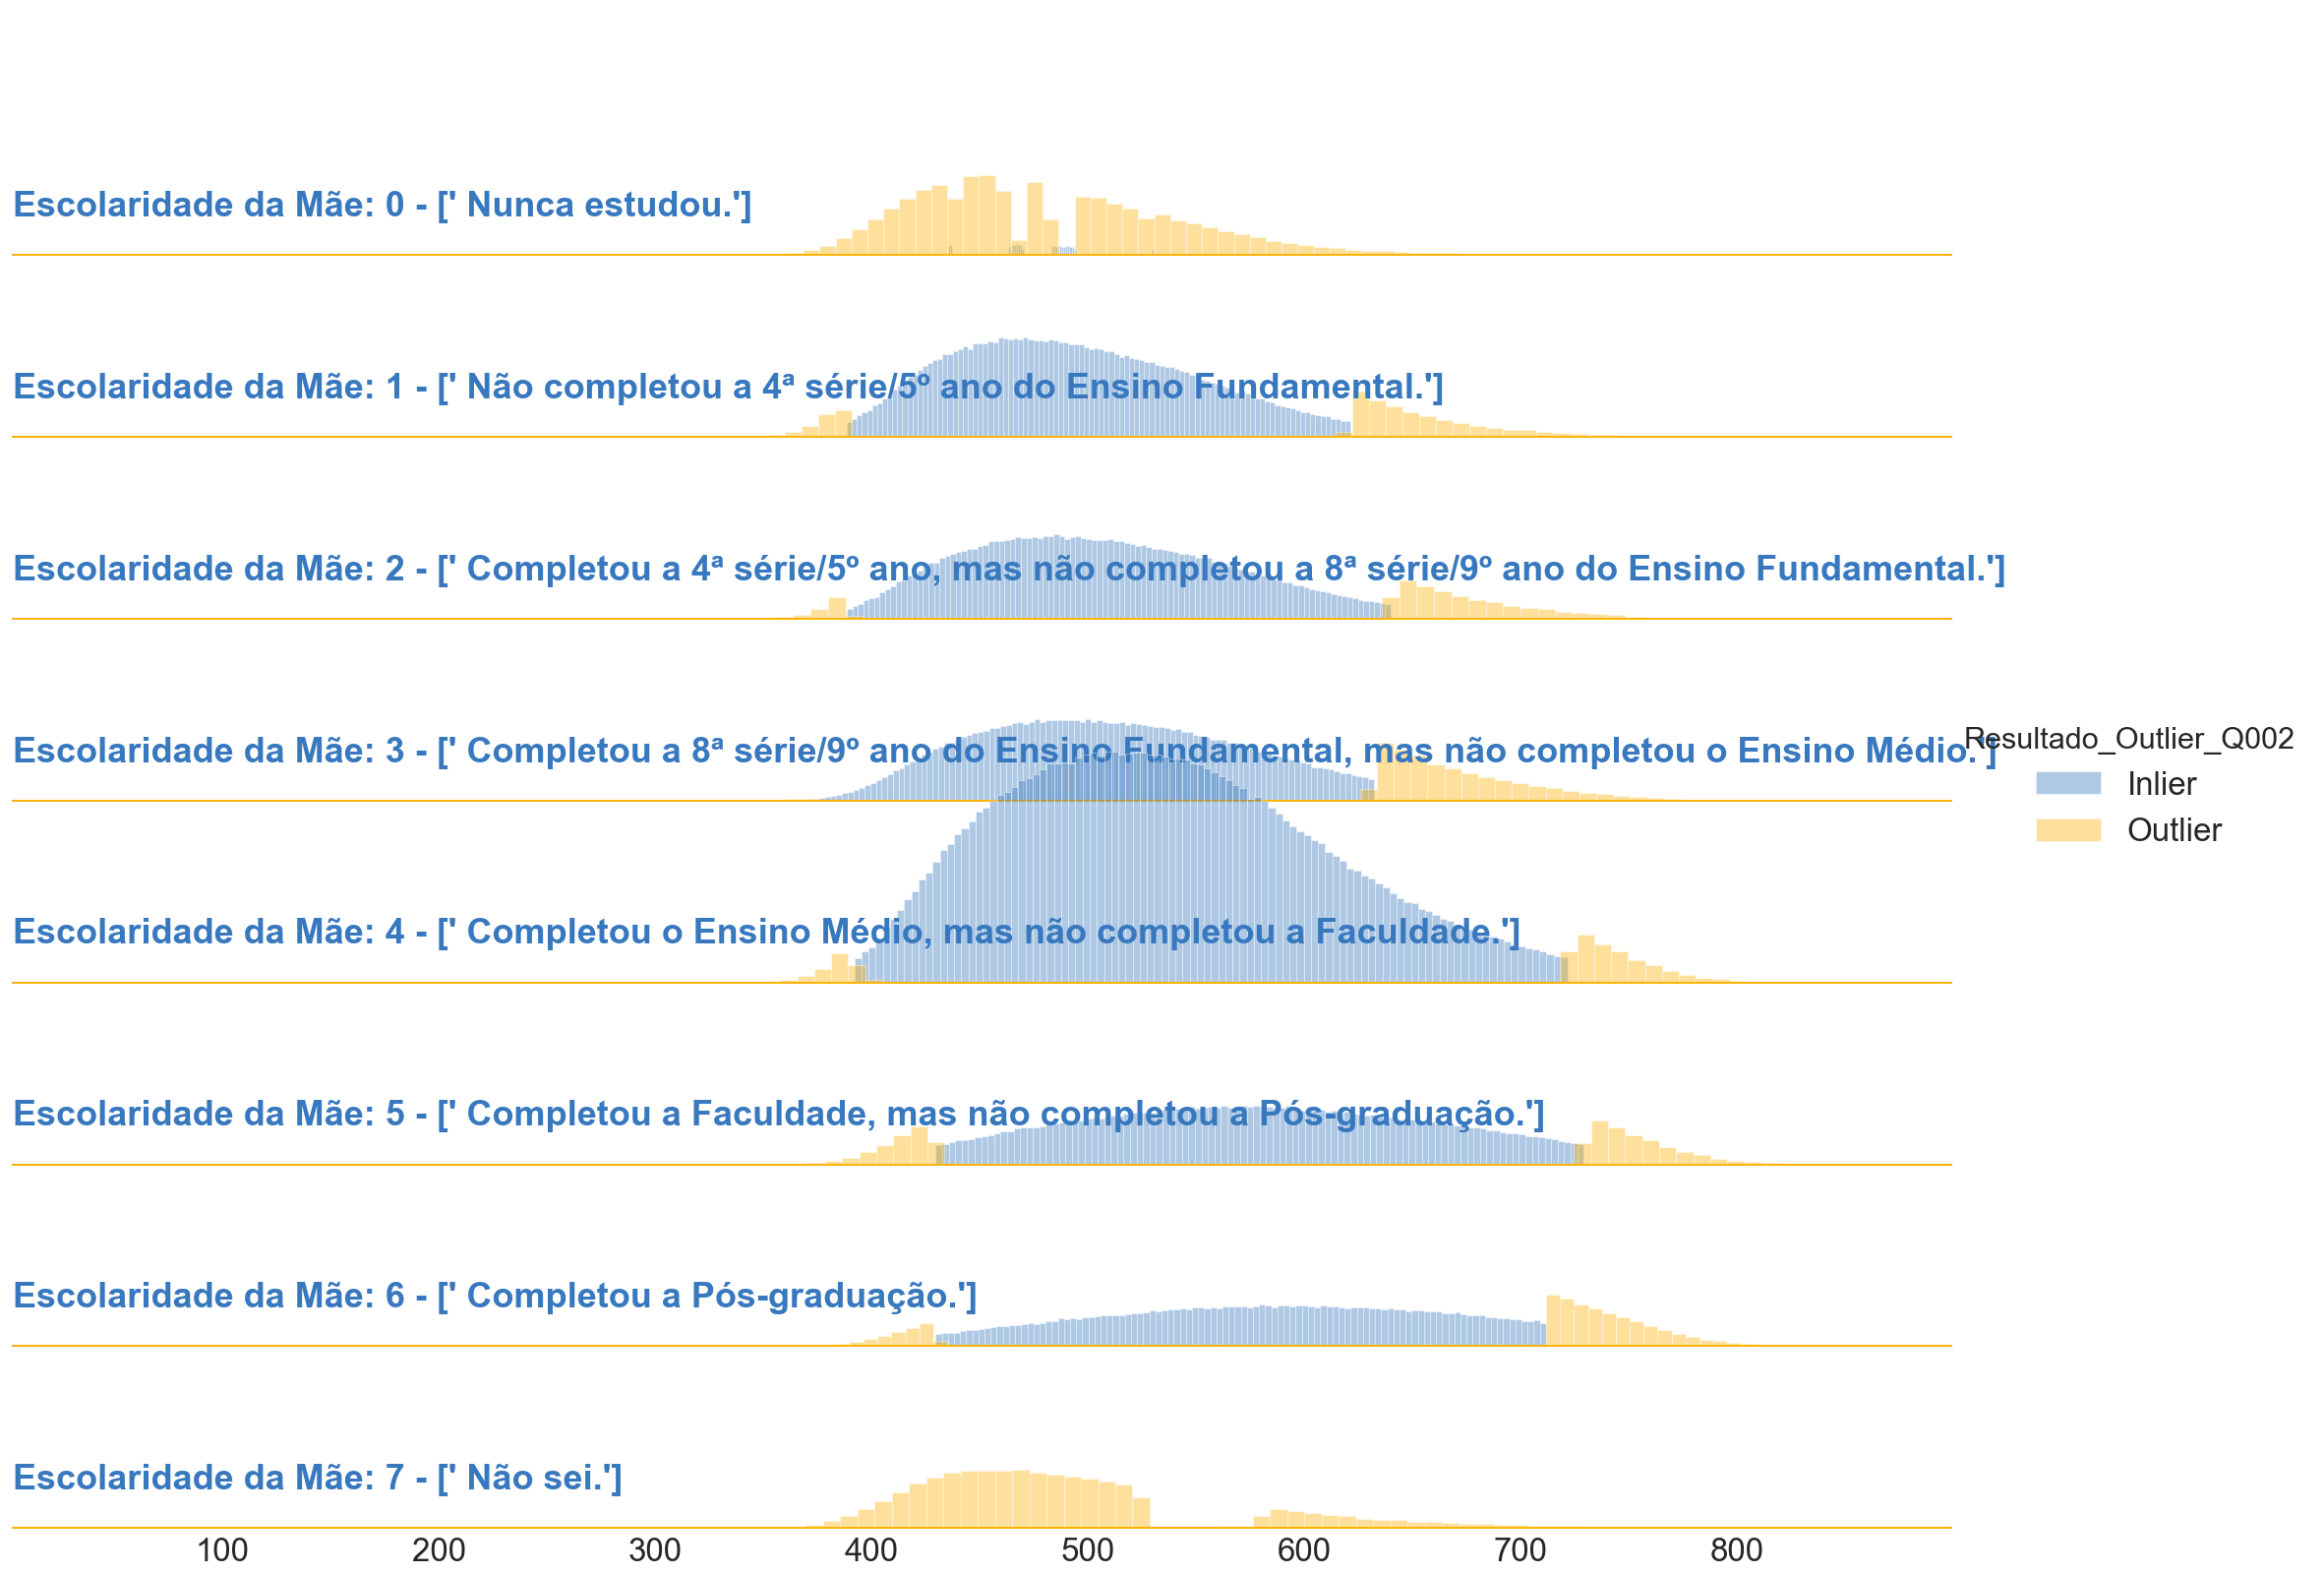

In [15]:
# Escolaridade da Mãe com Oulier
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=3)

colors = ["windows blue", "amber"]
pal = sns.xkcd_palette(colors)

# Initialize the FacetGrid object
g = sns.FacetGrid(dfEnem2018, row="Q002", hue="Resultado_Outlier_Q002", palette=pal, aspect=10)

# Draw the densities in a few steps
g.map(sns.distplot, "NU_NOTA_TOTAL", hist=True, kde=False, bins=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    if dfEnem2018.loc[x.index[0],'Resultado_Outlier_Q002'] == 'Inlier':
        ax.text(0, .2, 'Escolaridade da Mãe: ' + str(dfEnem2018.loc[x.index[0],'Q002']) + ' - ' + str(resp.loc[lambda y: (resp.Pergunta == 'Q002') & (resp.Opção == dfEnem2018.loc[x.index[0],'Q002']),'Resposta'].values), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

g.map(label, "NU_NOTA_TOTAL")
g.add_legend()


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.set(xlabel='')

#for value in sorted(dfEnem2018.Q006.unique()):
#    g.axes[value,0].set_xlabel(value, position = (.01,2))

<h2>Análise de hiperrepresentatividade das raças</h2>

In [91]:
#dfEnem2018["TP_COR_RACA_LEG"] = dfEnem2018["TP_COR_RACA"].map({'0': 'Não Declarado', '1': 'Branca', '2': 'Preta', '3': 'Preta', '4': 'Parda', '5': 'Indígena'})
#dfEnem2018["Q027_LEG"] = dfEnem2018["Q027"].map({'0': '0 - Escola Publica', '1': '1 - Parte publica e parte privada SEM bolsa', '2': '2 - Parte publica e parte privada COM bolsa', '3': '3 - Escola privada SEM bolsa', '4': '4 - Escola privada COM bolsa', '5': '5 - Não frequentei'})
#dfEnem2018["Q002_LEG"] = dfEnem2018["Q002"].map({'0': '0 - Nunca estudou', '1': '1 - Não completou a 4ª série/5º ano', '2': '2 - Não completou a 8ª série/9º', '3': '3 - Não completou o Ensino Médio.', '4': '4 - Não completou a Faculdade.', '5': '5 - Não completou a Pós-graduação.', '6': '6 - Completou a Pós-graduação.', '7': '7 - Não sei.'})
#dfEnem2018["Q006_LEG"] = dfEnem2018["Q006"].map({'0': '0 - Nenhuma renda.', '1': '1 - Até R$ 954,00.', '2': '2 - De R$ 954,01 até R$ 1.431,00.', '3': '3 - De R$ 1.431,01 até R$ 1.908,00.', '4': '4 - De R$ 1.908,01 até R$ 2.385,00.', '5': '5 - De R$ 2.385,01 até R$ 2.862,00.', '6': '6 - De R$ 2.862,01 até R$ 3.816,00.', '7': '7 - De R$ 3.816,01 até R$ 4.770,00.', '8': '8 - De R$ 4.770,01 até R$ 5.724,00.', '9': '9 - De R$ 5.724,01 até R$ 6.678,00.', '10': '10 - De R$ 6.678,01 até R$ 7.632,00.', '11': '11 - De R$ 7.632,01 até R$ 8.586,00.', '12': '12 - De R$ 8.586,01 até R$ 9.540,00.', '13': '13 - De R$ 9.540,01 até R$ 11.448,00.', '14': '14 - De R$ 11.448,01 até R$ 14.310,00.', '15': '15 - De R$ 14.310,01 até R$ 19.080,00.', '16': '16 - Mais de R$ 19.080,00.'})

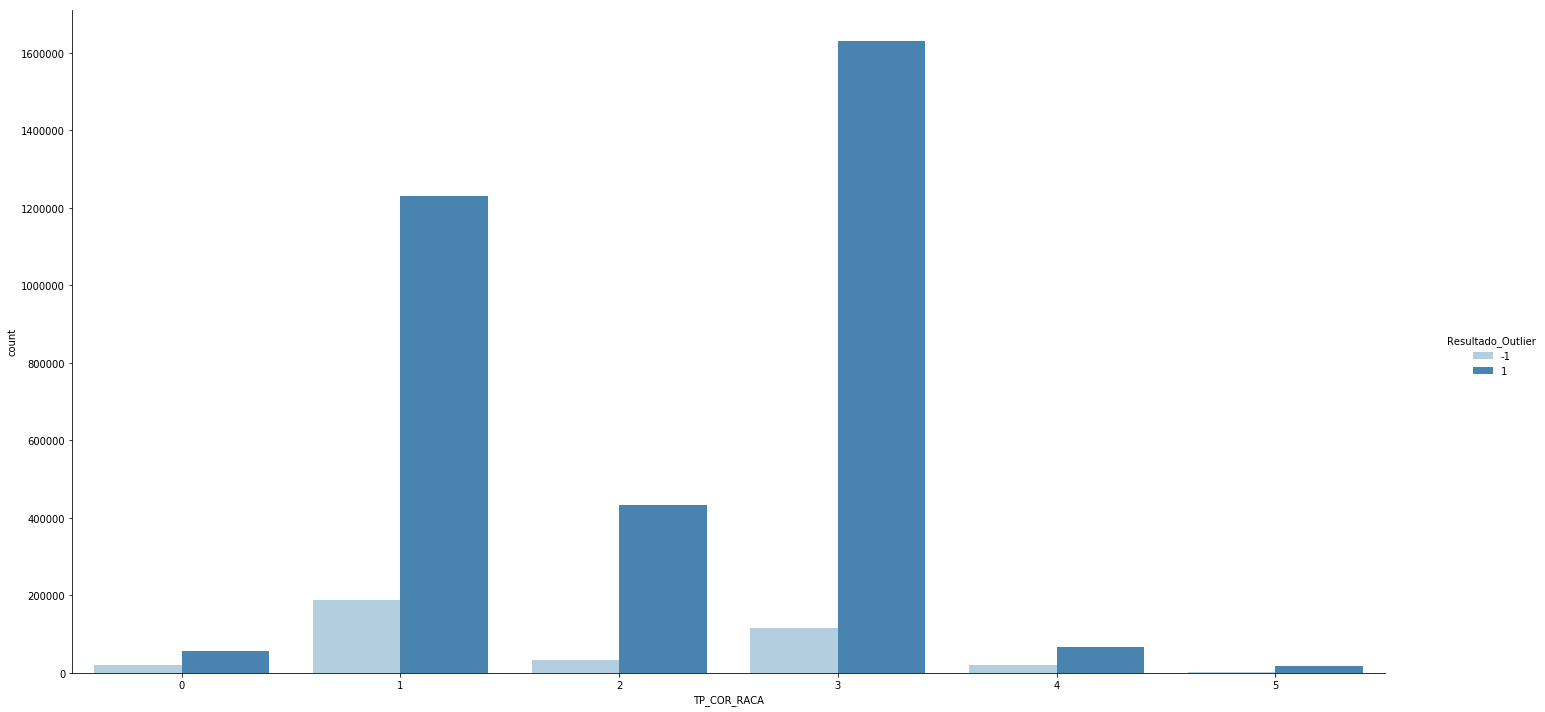

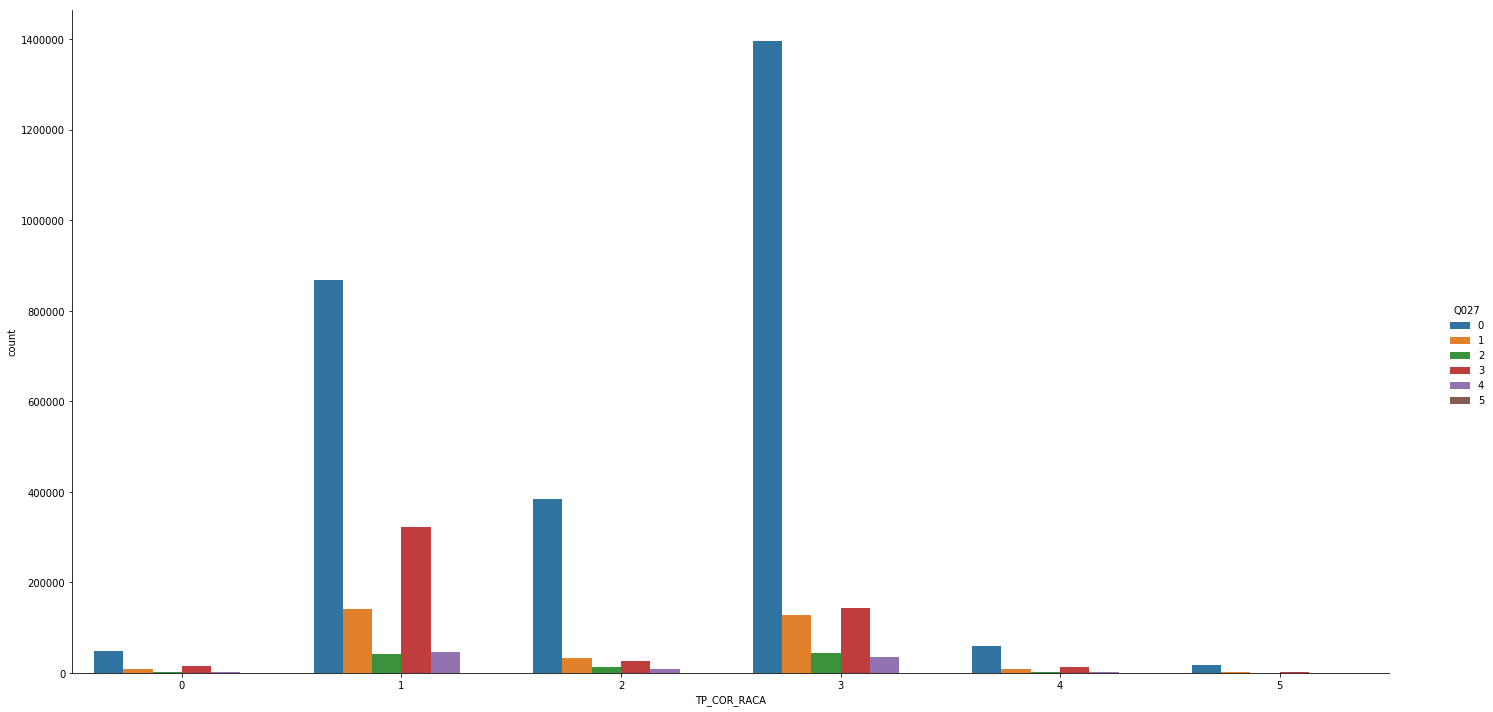

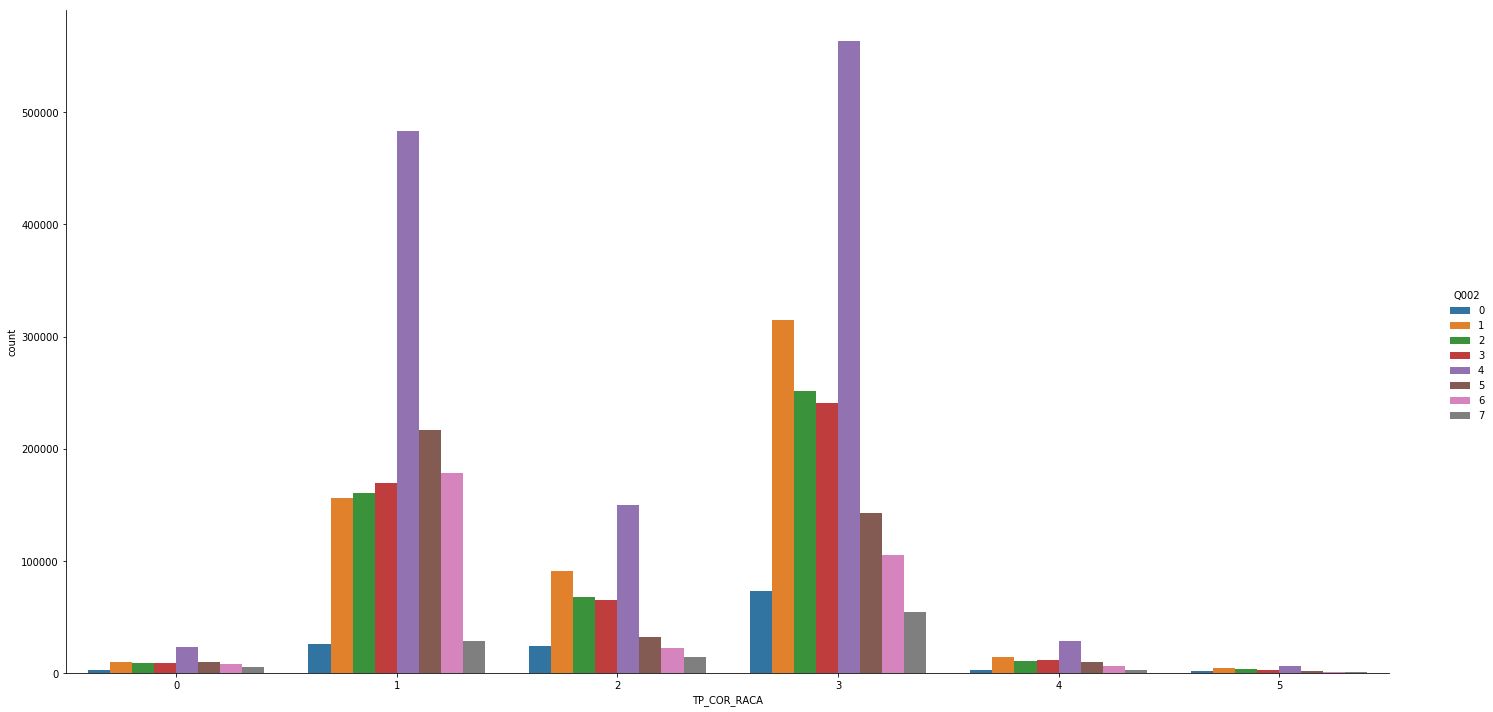

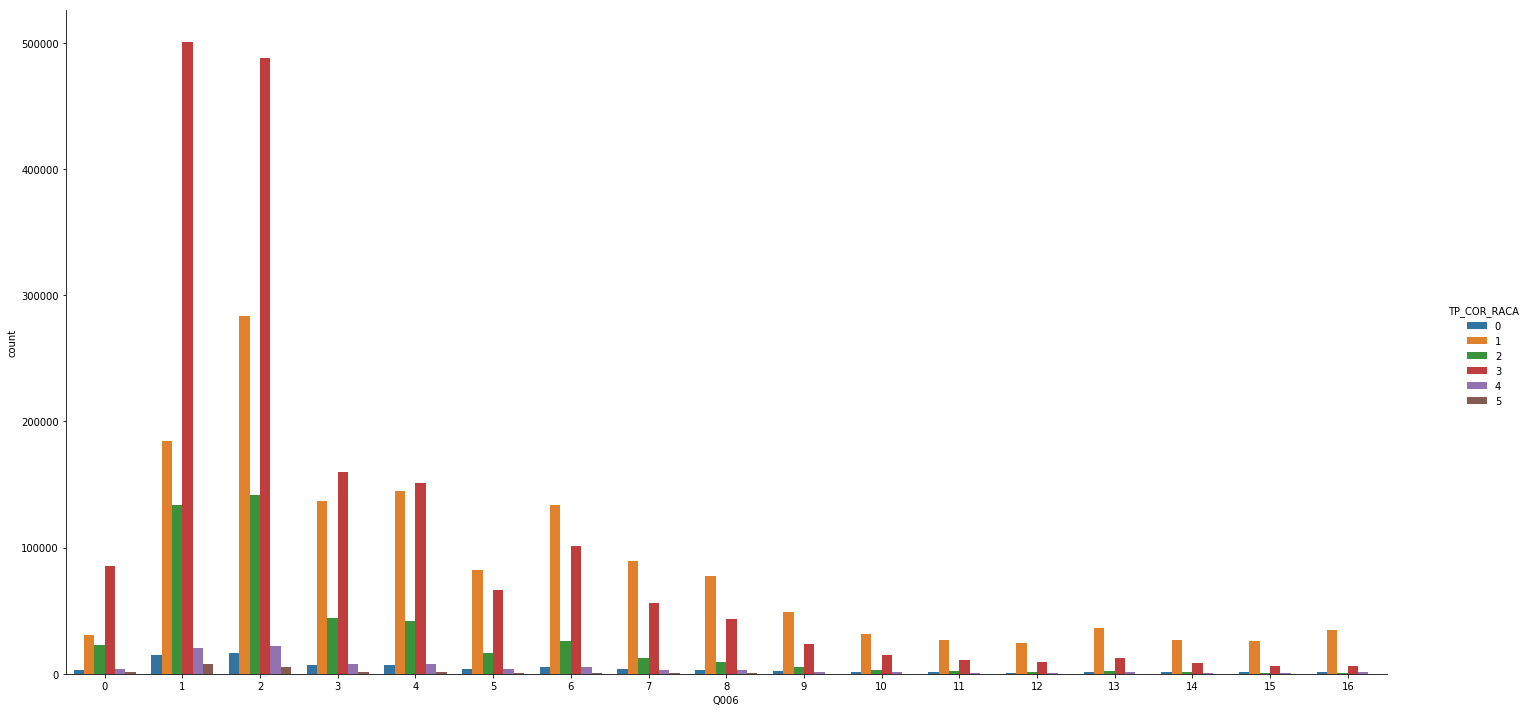

In [7]:
#Por outlier
sns.catplot(x="TP_COR_RACA", kind="count", hue="Resultado_Outlier", palette="Blues", data=dfEnem2018, aspect = 2, height = 10, margin_titles=True)

#Por escolaridade
sns.catplot(x="TP_COR_RACA", kind="count", hue="Q027", data=dfEnem2018, aspect = 2, height = 10, margin_titles=True)

#Por escolaridade da mãe
sns.catplot(x="TP_COR_RACA", kind="count", hue="Q002", data=dfEnem2018, aspect = 2, height = 10, margin_titles=True)

#Por renda
sns.catplot(x="Q006", kind="count", hue="TP_COR_RACA", data=dfEnem2018, aspect = 2, height = 10, margin_titles=True)

<h2>Proporção da Renda nos top 10%</h2>

Text(-21.2,0.5,'Quantidade')

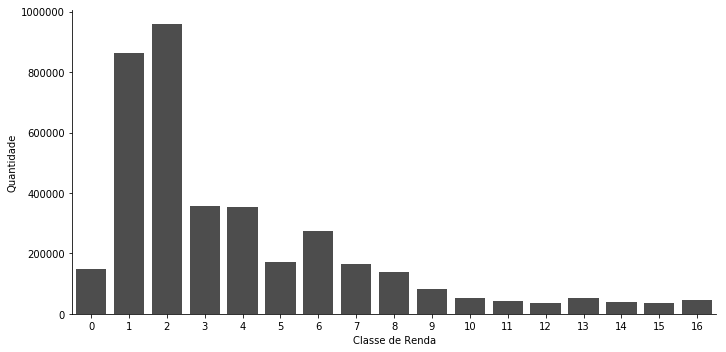

In [52]:
g = sns.catplot(x="Q006", kind="count", data=dfEnem2018, color=".3", aspect = 2, height = 5, margin_titles=True)
g.axes[0,0].set_xlabel('Classe de Renda')
g.axes[0,0].set_ylabel('Quantidade')

Text(-8.825,0.5,'Quantidade')

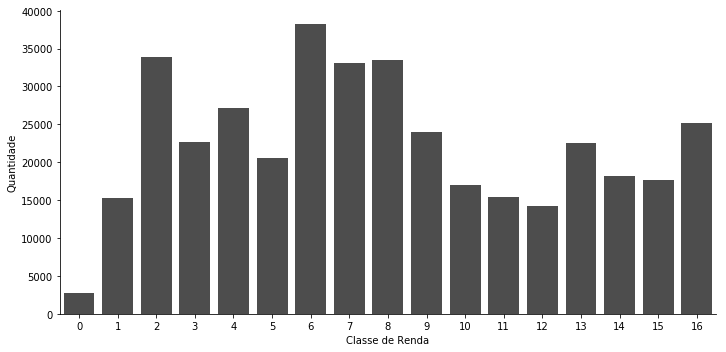

In [54]:
g = sns.catplot(x="Q006", kind="count", data=dfEnem2018.sort_values(by='NU_NOTA_TOTAL',ascending=False).head(int(dfEnem2018.shape[0]*.1)), color=".3", aspect = 2, height = 5, margin_titles=True)
g.axes[0,0].set_xlabel('Classe de Renda')
g.axes[0,0].set_ylabel('Quantidade')

[Text(0.5,0,'Classe de Renda')]

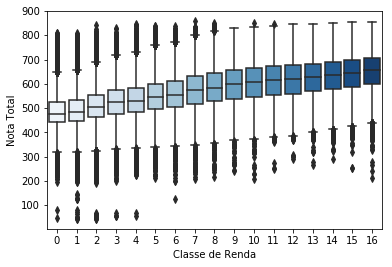

In [17]:
# RENDA

fig, axs = plt.subplots()


# Nota Total
sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette='Blues', ax = axs)

#u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'NU_NOTA_TOTAL']).size()).keys()))
#c = list(dict(dfEnem2018.groupby(['Q006','NU_NOTA_TOTAL']).size()).values())
#sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color=".25", edgecolor="grey", ax = axs[0])

#axs[0].set_title('Nota Total')
axs.set(ylabel='Nota Total')
axs.set(xlabel='Classe de Renda')

#fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
#fig.set_size_inches(18,15)

#BOXPLOT por renda
#0 = Nenhuma renda.
#1 = Até R$ 954,00.
#2 = De R$ 954,01 até R$ 1.431,00.
#3 = De R$ 1.431,01 até R$ 1.908,00.
#4 = De R$ 1.908,01 até R$ 2.385,00.
#5 = De R$ 2.385,01 até R$ 2.862,00.
#6 = De R$ 2.862,01 até R$ 3.816,00.
#7 = De R$ 3.816,01 até R$ 4.770,00.
#8 = De R$ 4.770,01 até R$ 5.724,00.
#9 = De R$ 5.724,01 até R$ 6.678,00.
#10 = De R$ 6.678,01 até R$ 7.632,00.
#11 = De R$ 7.632,01 até R$ 8.586,00.
#12 = De R$ 8.586,01 até R$ 9.540,00.
#13 = De R$ 9.540,01 até R$ 11.448,00.
#14 = De R$ 11.448,01 até R$ 14.310,00.
#15 = De R$ 14.310,01 até R$ 19.080,00.
#16 = Mais de R$ 19.080,00.

#sns.boxplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['NU_NOTA_TOTAL'], palette="Blues")

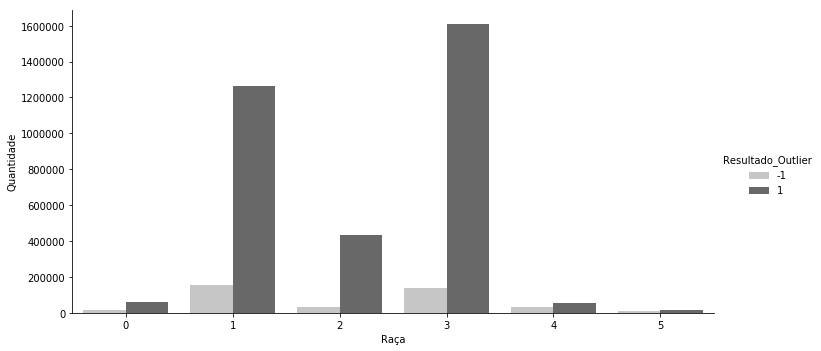

In [48]:

g = sns.catplot(x="TP_COR_RACA", kind="count", hue="Resultado_Outlier", palette="Greys", data=dfEnem2018, aspect = 2, height = 5)

g.axes[0,0].set_xlabel('Raça')
g.axes[0,0].set_ylabel('Quantidade')
g.axes[0,0].set_xticks=['Não declarado','Branco','Negro','Pardo','Amarelo','Indígena']

#axs.set(ylabel='Quantidade')
#axs.set(xlabel='Classe de Renda')

In [42]:
['Não declarado','Branco','Negro','Pardo','Amarelo','Indígena']

['Não declarado', 'Branco', 'Negro', 'Pardo', 'Amarelo', 'Indígena']

In [5]:
dfEnem2018['Q027_Resumido'] = dfEnem2018['Q027'].map({0: 'Somente escola pública', 1: 'Parte pública e parte privada, ou totalmente privada', 2: 'Parte pública e parte privada, ou totalmente privada', 3: 'Parte pública e parte privada, ou totalmente privada', 4: 'Parte pública e parte privada, ou totalmente privada', 5: 'Parte pública e parte privada, ou totalmente privada'})

dfEnem2018['Resultado_Outlier'] = dfEnem2018['Resultado_Outlier'].map({-1: 'Outlier', 1: 'Inlier'})
dfEnem2018['Resultado_Outlier'].head()

1    Inlier
5    Inlier
7    Inlier
8    Inlier
9    Inlier
Name: Resultado_Outlier, dtype: object

In [ ]:
dfEnem2018['Q006_Resumido'] = dfEnem2018['Q006'].map({0: 'Somente escola pública', 1: 'Parte pública e parte privada, ou totalmente privada', 2: 'Parte pública e parte privada, ou totalmente privada', 3: 'Parte pública e parte privada, ou totalmente privada', 4: 'Parte pública e parte privada, ou totalmente privada', 5: 'Parte pública e parte privada, ou totalmente privada'})

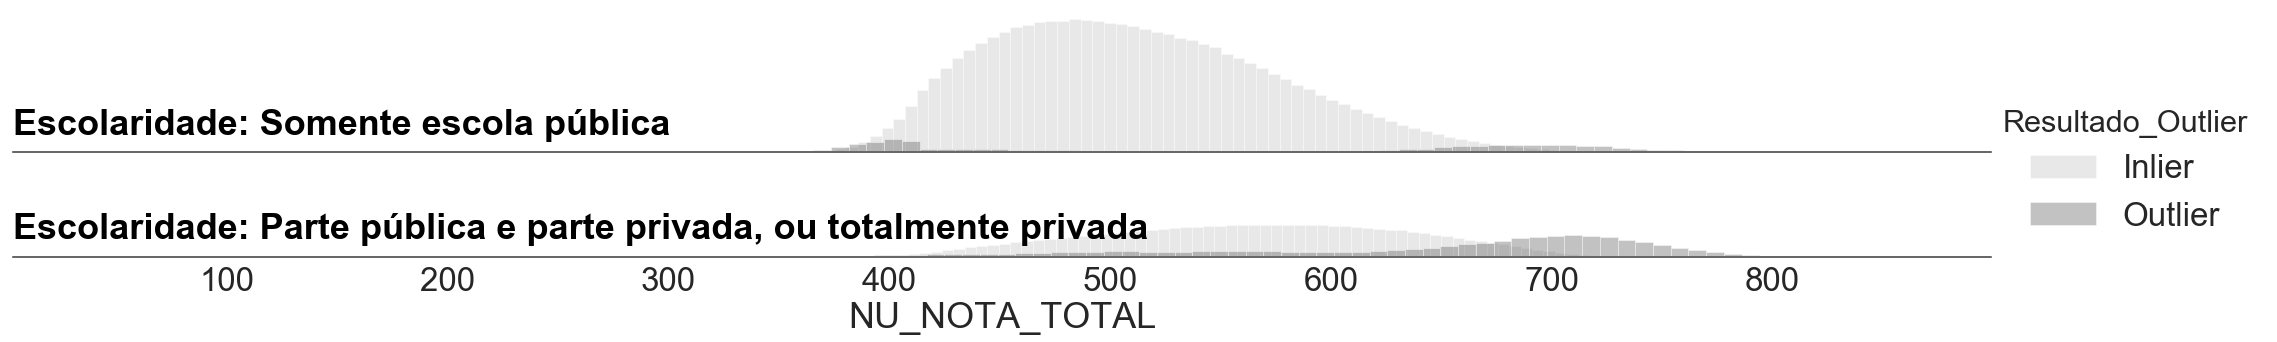

In [7]:
# Escolaridade com Oulier
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=3)

colors = ["windows blue", "amber"]
pal = sns.xkcd_palette(colors)

# Initialize the FacetGrid object
g = sns.FacetGrid(dfEnem2018, row="Q027_Resumido", hue="Resultado_Outlier", palette=pal, aspect=10)

# Draw the densities in a few steps
g.map(sns.distplot, "NU_NOTA_TOTAL", hist=True, kde=False, bins=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    if dfEnem2018.loc[x.index[0],'Resultado_Outlier_Q006'] == 'Inlier':
        ax.text(0, .2, 'Escolaridade: ' + str(dfEnem2018.loc[x.index[0],'Q027_Resumido']), fontweight="bold", color='0',
                ha="left", va="center", transform=ax.transAxes)

g.map(label, "NU_NOTA_TOTAL")
g.add_legend()


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

#for value in sorted(dfEnem2018.Q006.unique()):
#    g.axes[value,0].set_xlabel(value, position = (.01,2))

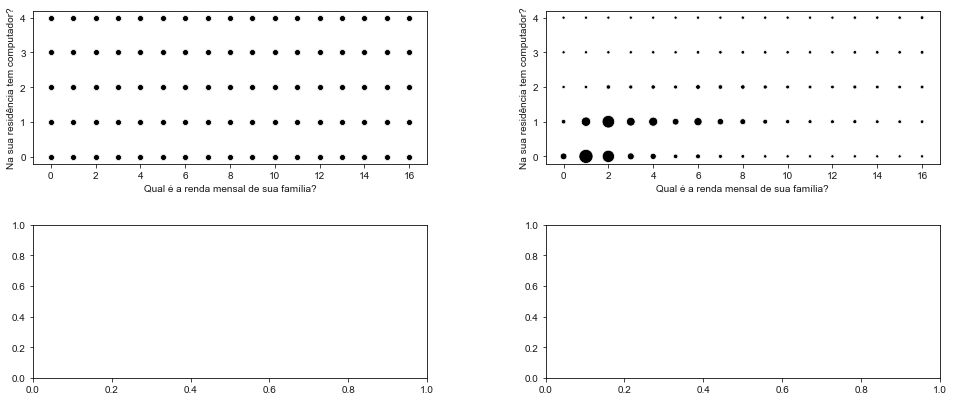

In [4]:
#Figura para o artigo

fig, axs = plt.subplots(2, 2)

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1)

sns.scatterplot(x=dfEnem2018['Q006'] ,y=dfEnem2018['Q024'],sizes=(10,200), color='0', ax = axs[0, 0])

axs[0, 0].set(ylabel='Na sua residência tem computador?')
axs[0, 0].set(xlabel='Qual é a renda mensal de sua família?')

u = np.asarray(list(dict(dfEnem2018.groupby(['Q006', 'Q024']).size()).keys()))
c = list(dict(dfEnem2018.groupby(['Q006','Q024']).size()).values())

sns.scatterplot(u[:,0],u[:,1],size=c,sizes=(10,200), color='0', ax = axs[0, 1], legend=False)

axs[0, 1].set(ylabel='Na sua residência tem computador?')
axs[0, 1].set(xlabel='Qual é a renda mensal de sua família?')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
fig.set_size_inches(14,6)